# Module 5 Project

* Student name: Bronwen Cohn-Cort
* Student pace: self-paced
* Scheduled project review date/time: July 8, 2020 3:15 PM (subject to change)
* Instructor name: Jeff Herman
* Blog post URL: https://bronwencc.github.io/data_science_using_lasso_and_ridge_regression_in_python

This notebook will look at a dataset of strategy games from the Apple App Store to get a model to predict whether an app has a higher (4.5 or 5) or lower (4 or under) Average User Rating.

The dataset is from https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games/ on the Kaggle website.  It was unzipped from the file `7k-apple-app-store-strategy-games.zip` to `appstore_games.csv`, contained in this repository.

The most accurate model is the `AdaBoostClassifier` and its optimal parameters were found to be `algorithm = 'SAMME.R'`, `learning_rate = 0.25` and `n_estimators = 75`.  With these parameters and the `finalbinsdf` dataframe (using eleven features), the highest accuracy is ~64% to predict whether a strategy game app's average rating is high (4.5 or 5) or low (4 or under).

# Obtain
### Import Statements

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
from xgboost import XGBClassifier

In [6]:
from scipy import stats

In [7]:
import time

In [8]:
import os

### Create "files" and "images" folders in directory

In [9]:
current = os.curdir
newfolders = ['files','images']
for newfolder in newfolders:
    newpath = os.path.join(current,newfolder)
    if not os.path.exists(newpath):
        os.makedirs(newpath)

### Simple Functions
These are to simplify resuming working on a dataframe saved as a .CSV file and other similarly useful blocks of code.

In [10]:
def getData(dfpath):
    '''
    A simple function to read in the requested, previously saved, .CSV file reached at dfpath as a pandas DataFrame with
    the first column becoming the index.
    
    Args
        dfpath (str) : the path from the current directory that contains the requested file
    
    Returns
        (pandas DataFrame) : the requested .CSV file as a DataFrame with the first column as the index
    '''
    mydf = pd.read_csv(dfpath, index_col=[0])#takes the first column to become the index
    return mydf

In [11]:
#creating dataframe of one column (named 1, as a number) with null values and the provided index
def emptyframe(specindex):
    '''
    Creates a pandas dataframe with the provided index with a sole column labeled 1 (as a number) consisting of NaN values.
    
    Args
        specindex (pandas DataFrame Index or similar) : The preferred index values for this new dataframe.
    
    Returns
        empdf (pandas DataFrame) : index is specindex, column titled 1 contains only NaN values for all of the index
    '''
    empdf = pd.DataFrame(data={1:np.nan},index=specindex)
    return empdf

## Pre-processing Data

In [12]:
#import data
#downloaded .zip file from https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games/
df = pd.read_csv("appstore_games.csv")
df.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [13]:
#looking at expected target data
df["Average User Rating"].value_counts(normalize=True)

4.5    0.378389
4.0    0.227748
5.0    0.130935
3.5    0.122338
3.0    0.067980
2.5    0.041926
2.0    0.020897
1.5    0.007935
1.0    0.001852
Name: Average User Rating, dtype: float64

# Scrub

In [14]:
 #dropping the rows which have a null value for Average User Rating (the target value)
df.dropna(axis='index', subset=["Average User Rating"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7561 entries, 0 to 16993
Data columns (total 18 columns):
URL                             7561 non-null object
ID                              7561 non-null int64
Name                            7561 non-null object
Subtitle                        2724 non-null object
Icon URL                        7561 non-null object
Average User Rating             7561 non-null float64
User Rating Count               7561 non-null float64
Price                           7561 non-null float64
In-app Purchases                4634 non-null object
Description                     7561 non-null object
Developer                       7561 non-null object
Age Rating                      7561 non-null object
Languages                       7537 non-null object
Size                            7561 non-null float64
Primary Genre                   7561 non-null object
Genres                          7561 non-null object
Original Release Date           7561 non-

`Subtitle`, `In-app Purchases`, and `Languages` still have null values outstanding.  The records missing `Languages` are a small percentage, so I will drop them.

In [15]:
print(f"Dropped {7561-7537} records that have null for Languages.")
df.dropna(axis='index',subset=["Languages"], inplace=True)
df.info()

Dropped 24 records that have null for Languages.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7537 entries, 0 to 16993
Data columns (total 18 columns):
URL                             7537 non-null object
ID                              7537 non-null int64
Name                            7537 non-null object
Subtitle                        2714 non-null object
Icon URL                        7537 non-null object
Average User Rating             7537 non-null float64
User Rating Count               7537 non-null float64
Price                           7537 non-null float64
In-app Purchases                4618 non-null object
Description                     7537 non-null object
Developer                       7537 non-null object
Age Rating                      7537 non-null object
Languages                       7537 non-null object
Size                            7537 non-null float64
Primary Genre                   7537 non-null object
Genres                          7537 non-null

In [16]:
#save df as .CSV for easy resuming later
df.to_csv("files/data7537.csv")

# Exploratory Data Analysis

Looking at the rest of the dataset to see what each is like:
1. Text:
    - Description
    - Developer
    - URL
    - Icon URL
    - Name
2. Numeric
    - ID
    - Original Release Date
    - Current Version Release Date
3. Histograms:
    - User Rating Count
    - Price
    - Size
4. `value_count`'s
    - Age Rating
    - Primary Genre
5. Dictionaries
    - Genres
    - In-app Purchases
    - Languages

In [17]:
#print in full: URL, Icon URL, Description, Developer, Name
for each in ["URL","Icon URL","Description","Developer","Name"]:
    for i in range(0,3):
        print(each, i,"\n", df.loc[i,each])

URL 0 
 https://apps.apple.com/us/app/sudoku/id284921427
URL 1 
 https://apps.apple.com/us/app/reversi/id284926400
URL 2 
 https://apps.apple.com/us/app/morocco/id284946595
Icon URL 0 
 https://is2-ssl.mzstatic.com/image/thumb/Purple127/v4/7d/23/c6/7d23c660-aba8-308a-05c0-19385a377c0e/source/512x512bb.jpg
Icon URL 1 
 https://is4-ssl.mzstatic.com/image/thumb/Purple128/v4/f7/e8/10/f7e810c8-72b4-cd85-e2d3-fbcb1e3ef381/source/512x512bb.jpg
Icon URL 2 
 https://is5-ssl.mzstatic.com/image/thumb/Purple118/v4/98/b2/41/98b241cc-29b7-5f67-0060-1e030f35562f/source/512x512bb.jpg
Description 0 
 Join over 21,000,000 of our fans and download one of our Sudoku games today!\n\nMakers of the Best Sudoku Game of 2008, Sudoku (Free), we offer you the best selling Sudoku game for iPhone with great features and 1000 unique puzzles! \n\nSudoku will give you many hours of fun and puzzle solving. Enjoy the challenge of solving Sudoku puzzles whenever or wherever you are using your iPhone or iPod Touch. \n\nO

Most of the columns with text would be best converted to a numerical or categorical representation, as the Natural Language Processing techniques required to explore the text data is beyond the scope of this project.  It is similarly beyond this project's scope to download and analyze all of the image files using the `Icon URL`.  The `URL` contains the same information already in `ID` and `Name` so that column is also unnecessary for this project. As each record presumably has a unique `ID` number, it could not be treated as a categorical variable and will not be useful for modeling.

In [18]:
#checking to see if it might make sense to have Name be a function of frequency; if several are named Sudoku, for example
df.Name.value_counts()

Backgammon Unlimited                   2
Tap The Egg And You Might Win          2
WW2 TD Battlefield Heroes              2
Rust Bucket                            2
Sportimo                               2
                                      ..
Color Block Flow - Tricky Challenge    1
Civil War: 1863                        1
Solarmax2                              1
Throne: Kingdom at War                 1
Wicked Snow White                      1
Name: Name, Length: 7464, dtype: int64

Slightly more advanced Natural Language Processing techniques can categorize `Name`, `Developer`, `Subtitle` and `Description` to find all of the Sudoku games, for example, but in this project they will be reduced to simple functions of their lengths.

No name (without any processing) appears more than twice, so the length of the String of `Name` will be the proxy for this feature in the modeling.  However, with a number of distinct names that appear more than once (such as "Silde Me! - Jigsaw Puzzle Pro Ultimate edition"), it looks as though the data has duplicate records.  A check of the `ID`, presumed to be unique, will confirm this suspicion.

In [19]:
#seeing if the ID column also has several duplicates
df.ID.value_counts()

642313308     2
1042336481    2
522314512     2
1138713731    2
961338039     2
             ..
1082667587    1
1046825540    1
1255031365    1
1461475910    1
955957248     1
Name: ID, Length: 7464, dtype: int64

### Handling Duplicates of Names and ID's
Filtering the records with the same `Name` and the same `ID` to see how similar the rest of the information is.

In [20]:
def listduplicates(indexedseries):
    '''
    It takes in a series, assumed to be from dataframe["column name"].value_counts(), where its index is the value and 
    the corresponding number is the frequency of that value appearing in "column name".
    
    Args
        indexedseries (pandas Series) : a series of integers with an index made up of the measured quantities/values
    
    Returns
        serieslist (list) : a list of indexedseries index values that had corresponding integers greater than 1. If the 
                            indexedseries provided is directly from pandas value_counts() of a column, serieslist contains
                            those original values from that column that appeared more than once.
    '''
    serieslist=[]
    for value,count in zip(indexedseries.index,indexedseries):#count is an integer
        if count>1:#if value appears more than once in series, count is greater than 1
            serieslist.append(value)#adding the recurring item from series' index to a list
    return serieslist

In [21]:
#looking at the first five ID's that appear twice
idvals = listduplicates(df.ID.value_counts())
idvals[:5]

[642313308, 1042336481, 522314512, 1138713731, 961338039]

In [22]:
#getting a list of the app names that appear more than once
samenames = listduplicates(df.Name.value_counts())

In [23]:
#creating a dataframe by filtering for the records with app names that appear more than once
namedf = df[df["Name"].isin(samenames)]
namedf.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
15,https://apps.apple.com/us/app/awele-oware-manc...,289217958,Awele/Oware - Mancala HD,NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015
16,https://apps.apple.com/us/app/awele-oware-manc...,289217958,Awele/Oware - Mancala HD,NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015
123,https://apps.apple.com/us/app/checkers/id32102...,321026028,Checkers,Checkers (Draughts) & puzzles.,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,4.5,36581.0,0.0,NaN,"Checkers (also called ""Draughts"") is challengi...",Vintolo Ltd,4+,EN,69393408.0,Games,"Games, Entertainment, Board, Strategy",4/07/2009,14/06/2019
124,https://apps.apple.com/us/app/checkers/id32102...,321026028,Checkers,Checkers (Draughts) & puzzles.,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,4.5,36581.0,0.0,NaN,"Checkers (also called ""Draughts"") is challengi...",Vintolo Ltd,4+,EN,69393408.0,Games,"Games, Entertainment, Board, Strategy",4/07/2009,14/06/2019
234,https://apps.apple.com/us/app/bungee-stickmen-...,348741265,Bungee Stickmen - Australian Landmarks {LITE +},NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,1229.0,0.0,"37.99, 199.99, 0.99",\u2588 Have hours of fun doing 180 jumps in th...,Poulet Maison Ptd Ltd,12+,"ZH, EN, FR, DE, IT, JA, ES",10781853.0,Medical,"Medical, Adventure, Strategy, Games",13/01/2010,27/02/2010


In [24]:
#check to see whether every record in the dataframe based on duplicate names has a double for ID as well
namedf.ID.value_counts()

1367755773    2
944393348     2
1269916759    2
1308856791    2
1236846171    2
             ..
1015000630    2
1292539617    2
961338039     2
1270821305    2
1058245379    2
Name: ID, Length: 73, dtype: int64

In [25]:
#create dataframe based on ID duplicates
idendf = df[df["ID"].isin(idvals)]
#look at the app names for whether they also appear more than once
idendf.Name.value_counts()

Sport Car Driving: City Advent                     2
Dice 50                                            2
Battle On The Sea for iPad                         2
KillZ - idle clicker rpg                           2
Fort Sumter: Secession Crisis                      2
                                                  ..
DayD Tower Rush HD                                 2
"Papa's Scooperia To Go!"                          2
Happy Chef 2                                       2
Expert Plumber Puzzle - Fix The Pipe-line Crack    2
Repair The Bridge Mania Lite                       2
Name: Name, Length: 73, dtype: int64

Similarly to `namedf`, it appears that all records in `idendf` are twins.

In [26]:
#looking at an example to see whether other variables are the same and what the frame looks like
idendf.head(6)

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
15,https://apps.apple.com/us/app/awele-oware-manc...,289217958,Awele/Oware - Mancala HD,NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015
16,https://apps.apple.com/us/app/awele-oware-manc...,289217958,Awele/Oware - Mancala HD,NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015
123,https://apps.apple.com/us/app/checkers/id32102...,321026028,Checkers,Checkers (Draughts) & puzzles.,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,4.5,36581.0,0.0,NaN,"Checkers (also called ""Draughts"") is challengi...",Vintolo Ltd,4+,EN,69393408.0,Games,"Games, Entertainment, Board, Strategy",4/07/2009,14/06/2019
124,https://apps.apple.com/us/app/checkers/id32102...,321026028,Checkers,Checkers (Draughts) & puzzles.,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,4.5,36581.0,0.0,NaN,"Checkers (also called ""Draughts"") is challengi...",Vintolo Ltd,4+,EN,69393408.0,Games,"Games, Entertainment, Board, Strategy",4/07/2009,14/06/2019
234,https://apps.apple.com/us/app/bungee-stickmen-...,348741265,Bungee Stickmen - Australian Landmarks {LITE +},NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,1229.0,0.0,"37.99, 199.99, 0.99",\u2588 Have hours of fun doing 180 jumps in th...,Poulet Maison Ptd Ltd,12+,"ZH, EN, FR, DE, IT, JA, ES",10781853.0,Medical,"Medical, Adventure, Strategy, Games",13/01/2010,27/02/2010
235,https://apps.apple.com/us/app/bungee-stickmen-...,348741265,Bungee Stickmen - Australian Landmarks {LITE +},NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,1229.0,0.0,"37.99, 199.99, 0.99",\u2588 Have hours of fun doing 180 jumps in th...,Poulet Maison Ptd Ltd,12+,"ZH, EN, FR, DE, IT, JA, ES",10781853.0,Medical,"Medical, Adventure, Strategy, Games",13/01/2010,27/02/2010


The first two records of `idendf` are identical from the information displayed.  Next, the merging of the `idendf` and the `namedf` on the `ID` column.

In [27]:
#joining the dataframes idendf and namedf, where ID is the same
doubledf = pd.merge(idendf, namedf, on='ID', how='outer')

In [28]:
#checking for null values, which would indicate where one dataframe had a record that the other did not
doubledf.isna().sum()

URL_x                               0
ID                                  0
Name_x                              0
Subtitle_x                        192
Icon URL_x                          0
Average User Rating_x               0
User Rating Count_x                 0
Price_x                             0
In-app Purchases_x                112
Description_x                       0
Developer_x                         0
Age Rating_x                        0
Languages_x                         0
Size_x                              0
Primary Genre_x                     0
Genres_x                            0
Original Release Date_x             0
Current Version Release Date_x      0
URL_y                               0
Name_y                              0
Subtitle_y                        192
Icon URL_y                          0
Average User Rating_y               0
User Rating Count_y                 0
Price_y                             0
In-app Purchases_y                112
Description_

The 'outer' merge just performed would put null values for records that had an `ID` in one dataframe and not the other. The merged dataframe `doubledf` has null values in only four columns and all columns of `_x` or `_y` would need at least one null value to indicate at least one record did not match. Since this shows there are no entire records in `_x` columns or `_y` columns with null values, the two dataframes `namedf` and `idendf` contain only records with the same `ID`'s.

In addition, the merged dataframe indicates `idendf` and `namedf` have the same number of null values in the same columns (`Subtitle` and `In-app Purchases`).  Below, there's a comparison of the shapes of all three dataframes to check the math.

In [29]:
#compare number of rows and columns in each dataframe
for frame in [doubledf,namedf,idendf]:
    print(frame.shape)

(292, 35)
(146, 18)
(146, 18)


$18+18$ adds to $36$, but since the dataframes were merged on the `ID` column, there would be $35$ columns in the combined `doubledf`.  Also, the merge doubled the rows so as to include all records from the `ID` column of each ($146+146=292$).

Since the records are the same, I could use either a duplicate's `Name` or `ID` to remove one copy of each duplicate record from `df`.

In [30]:
print(idendf.shape)
print(f"The code will remove {idendf.shape[0]/2} records from the {df.shape[0]} total, resulting in {7537-73} records.")

(146, 18)
The code will remove 73.0 records from the 7537 total, resulting in 7464 records.


In [31]:
#remove records from dataframe, using idendf's index to match appropriate rows, as the index has not been reset
#and it still matches up with the original index from df
duplindices=[]
for n, i in enumerate(idendf.index):
    if n%2 != 0:#gets every other index from idendf since each record neighbors its duplicate
        duplindices.append(i)#adds the index to list to be dropped
#new dataframe without every other index of the duplicates
edadf = df.drop(index=duplindices)

In [32]:
#find how many ID's appear more than once
edadfids = listduplicates(edadf.ID.value_counts())
print(f"Duplicate ID count for EDA dataframe: {len(edadfids)}")

Duplicate ID count for EDA dataframe: 0


In [33]:
edadf.shape

(7464, 18)

In [34]:
#save edadf as CSV to resume later
edadf.to_csv("files/data7464.csv")

In [35]:
edadf = getData("files/data7464.csv")
#checking the dataframe is read in as expected
edadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 18 columns):
URL                             7464 non-null object
ID                              7464 non-null int64
Name                            7464 non-null object
Subtitle                        2689 non-null object
Icon URL                        7464 non-null object
Average User Rating             7464 non-null float64
User Rating Count               7464 non-null float64
Price                           7464 non-null float64
In-app Purchases                4573 non-null object
Description                     7464 non-null object
Developer                       7464 non-null object
Age Rating                      7464 non-null object
Languages                       7464 non-null object
Size                            7464 non-null float64
Primary Genre                   7464 non-null object
Genres                          7464 non-null object
Original Release Date           7464 non-

### Continuing with Name EDA

In [36]:
edadf.Name.head(10)

0                             Sudoku
1                            Reversi
2                            Morocco
3                      Sudoku (Free)
4                       Senet Deluxe
5     Sudoku - Classic number puzzle
7                             Colony
8                              Carte
9                   "Barrels O' Fun"
11                        Lumen Lite
Name: Name, dtype: object

The number of characters in the title will become a numerical proxy for the Name variable.

In [37]:
namelengthdf = emptyframe(edadf.index)
namelengthdf[1]=edadf.Name
namelengthdf["NameLength"] = [len(name) for name in edadf["Name"]]
namelengthdf.head()

,1,NameLength
0,Sudoku,6
1,Reversi,7
2,Morocco,7
3,Sudoku (Free),13
4,Senet Deluxe,12


### Understanding Subtitle column

In [38]:
#Looking at Subtitle:
edadf[edadf["Subtitle"].notna()].head(8)

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
5,https://apps.apple.com/us/app/sudoku-classic-n...,286210009,Sudoku - Classic number puzzle,Original brain training,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.0,47.0,0.00,1.99,"Sudoku will tease your brain, challenge you or...",OutOfTheBit Ltd,4+,EN,48672768.0,Games,"Games, Entertainment, Strategy, Puzzle",30/07/2008,29/04/2019
19,https://apps.apple.com/us/app/cool-sudoku-jigs...,290614255,"Cool Sudoku, Jigsaw, Killer","Sudoku, Jigsaw, Killer, Kakuro",https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.5,357.0,0.00,"0.99, 0.99, 0.99","You can now play Sudoku, Killer Sudoku, Jigsaw...",Splash Software Ltd.,4+,EN,52236288.0,Games,"Games, Strategy, Puzzle, Entertainment",24/09/2008,26/04/2019
27,https://apps.apple.com/us/app/lux-touch-3-worl...,292538570,Lux Touch 3 - World Domination,Game of Global Conquest,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,72428.0,0.00,NaN,Lux is a game of strategy and world conquest!\...,Sillysoft Games,9+,EN,55071744.0,Games,"Games, Entertainment, Strategy, Board",7/10/2008,23/01/2019
33,https://apps.apple.com/us/app/chess-tchess-pro...,295445501,Chess - tChess Pro,For beginners to professionals,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3062.0,7.99,NaN,"tChess Pro is the high-quality, critically acc...",Tom Kerrigan,4+,"EN, FR, DE, JA, KO, ZH",7517184.0,Games,"Games, Board, Entertainment, Strategy",5/11/2008,7/04/2019
36,https://apps.apple.com/us/app/chess-tchess-lit...,296756437,Chess - tChess Lite,Fun and easy to use,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,5488.0,0.99,NaN,tChess Lite is the popular chess game designed...,Tom Kerrigan,4+,"EN, FR, DE, JA, KO, ZH",5874688.0,Games,"Games, Strategy, Entertainment, Board",15/11/2008,7/04/2019
45,https://apps.apple.com/us/app/lux-dlx-3-map-co...,299813413,Lux DLX 3 - Map Conquest Game,World Domination Supreme!,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,4.0,5629.0,4.99,NaN,Lux DLX is an epic game of strategy & conquest...,Sillysoft Games,9+,"DA, NL, EN, FR, DE, IT, NO, NB, PT, ES, SV",93993984.0,Games,"Games, Strategy, Board, Entertainment",19/12/2008,26/03/2019
55,https://apps.apple.com/us/app/arcs/id302510211,302510211,Arcs,Circular puzzle game,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,4.0,413.0,2.99,NaN,Arcs is a spin on the classic sliding tile puz...,Pomegranate Apps LLC,4+,EN,5106688.0,Games,"Games, Puzzle, Entertainment, Strategy",21/01/2009,10/05/2018
66,https://apps.apple.com/us/app/omar-sharif-brid...,304878580,Omar Sharif Bridge,2019 Edition,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,2.5,359.0,5.99,NaN,Welcome to the 2019 edition of Omar Sharif Bri...,ZingMagic Limited,4+,EN,33982464.0,Games,"Games, Card, Entertainment, Strategy",17/02/2009,11/12/2018


The `Subtitle` column seems to have a short description or tagline of the app. It could be combined into the `Description` or drop the column itself, as losing a third of the records ($\frac{2714}{7464}$ have it) would be a lot.
However, this information will be used to create a categorical variable of whether an app has a subtitle or not.

Also found good examples of Subtitles for the presentation:

In [39]:
for i in [19,33,36,55]:
    try:
        print(i,"\n", edadf.loc[i,"Name"],"\n",edadf.loc[i,"Subtitle"])
    except:
        print(i,"\n","what")
        continue

19 
 Cool Sudoku, Jigsaw, Killer 
 Sudoku, Jigsaw, Killer, Kakuro
33 
 Chess - tChess Pro 
 For beginners to professionals
36 
 Chess - tChess Lite 
 Fun and easy to use
55 
 Arcs 
 Circular puzzle game


In [40]:
#example indices without subtitles
for i in [32,34,35,37]:
    try:
        print(i,"\n", edadf.loc[i,"Name"])
    except:
        print(i,"\n","what")
        continue

32 
 Chess Genius
34 
 Toobz
35 
 Color Sudoku
37 
 Checkers Online Lite


### Looking at Developer column - possible categorization
Considering whether `Developer` could become categorical, or a function of frequency, or `String` length.

In [41]:
edadf["Developer"].value_counts()

Tapps Tecnologia da Informa\xe7\xe3o Ltda.    113
Detention Apps                                 38
Qumaron                                        36
EASY Inc.                                      35
HexWar Games Ltd                               32
                                             ... 
Cl\xe9ment jacquet                              1
Kikaku Damashii, Inc                            1
FUSEE                                           1
Ilya Kovalenko                                  1
Ying Zhang                                      1
Name: Developer, Length: 4261, dtype: int64

One way to categorize these is by whether they end in Ltd, GmbH, Inc, Corp, SL, LLC, or similar designations of private companies.

In [42]:
def isco(developername, abbreviations=["Ltd","Ltda","Inc","GmbH","SL","LLC","Corp","AB","AG","Co"]):
    '''
    This determines for a String (developername) whether its last several characters, excepting a final period, match a 
    String contained in abbreviations, which defaults to a common abbreviation for a company.
    
    Args
        developername (str) : assuming it takes the form of "Developer Name Ltd."
        abbreviations (list or iterable arraylike) : a list of Strings to match to the end of developername, which
                                                defaults to a list of common abbreviations, expected to have no punctuation
    
    Returns
        (bool): True indicating it is a match, False indicating it does not end in one of the Strings in abbreviations
    '''
    developername = developername.strip() #remove trailing and leading spaces
    
    if(developername[-1]=="."):
        developername=developername[:-1] #if the last char is a period, it will be dropped from the String
        
    for abbrev in abbreviations:
        try:
            lastfew = developername[-(len(abbrev)+1):] #selecting one more than the number of characters from developername
                                                        #than are in the current abbrev
            lastfew = lastfew.strip() #remove trailing and leading spaces
        except:
            continue #if developername contains only about as many characters as are in abbrev, it is too
                    #short a developername to qualify as matching this abbrev
        if(lastfew.lower()==abbrev.lower()):#if the end of developername and the abbrev match
            return True
        else:
            continue
    #After going through every abbreviation and not finding a match, False is returned
    #The method would have returned True and ended by now if it had found a match so the result must be False
    #print(developername, "this was found to be false")
    return False

In [43]:
#create new dataframe of only developer and True/False column generated by isco() list comprehension
devcodf = emptyframe(edadf.index)
devcodf[1]=edadf.Developer
#create column of whether Developer ends in an abbreviation (1) or not (0)
devcodf["IsCompany"] = [1 if isco(dev) else 0 for dev in edadf["Developer"]] #if it ends in an abbreviation, returns True
devcodf.head()

,1,IsCompany
0,Mighty Mighty Good Games,0
1,Kiss The Machine,0
2,Bayou Games,0
3,Mighty Mighty Good Games,0
4,RoGame Software,0


In [44]:
#further looking at results from isco
devcodf[devcodf.IsCompany>0].tail()

,1,IsCompany
16601,Childish Things Ltd,1
16638,Misquamicut Technologies LLC,1
16651,JoyBits Ltd.,1
16758,Appscalibur LLC,1
16863,Phoenix One Games Inc.,1


In [45]:
devcodf.IsCompany.value_counts(normalize=True)

0    0.740622
1    0.259378
Name: IsCompany, dtype: float64

Almost 26% of records have a `Developer` name that ends with a common abbreviation for a company.

### Understanding Genres and Primary Genre
The difference between Primary Genre and Genres is that the former has only one genre, and the latter lists a number of genres associated with the app. As this dataset is a list of strategy games, it makes sense that the most common genres are "Games" and "Strategy".

In [46]:
edadf["Genres"].value_counts(normalize=True)

Games, Simulation, Strategy                 0.038585
Games, Strategy, Simulation                 0.038049
Games, Strategy, Puzzle                     0.034566
Games, Strategy, Action                     0.034164
Games, Puzzle, Strategy                     0.028805
                                              ...   
Games, Strategy, Food & Drink, Casual       0.000134
Games, Role Playing, Strategy, Reference    0.000134
Education, Strategy, Games, Puzzle          0.000134
Lifestyle, Games, Trivia, Strategy          0.000134
Games, Family, Lifestyle, Strategy          0.000134
Name: Genres, Length: 622, dtype: float64

Most of `Genres` appears to be a list of genres for a record. The genres that look common are Games, Strategy, and Simulation. In fact, that trio is the most commonly-appearing list; 7.6% ($0.038\times2$) of records fall into solely those three. It would be interesting to consider this feature as a frequency dictionary, separating out the genres from each list.

In [47]:
edadf["Primary Genre"].value_counts(normalize=True)

Games                0.964094
Entertainment        0.012326
Education            0.006163
Utilities            0.005895
Sports               0.003081
Reference            0.002412
Productivity         0.001072
Finance              0.001072
Book                 0.000670
Lifestyle            0.000536
Social Networking    0.000402
Stickers             0.000402
Music                0.000402
News                 0.000268
Business             0.000268
Health & Fitness     0.000268
Medical              0.000134
Travel               0.000134
Food & Drink         0.000134
Shopping             0.000134
Navigation           0.000134
Name: Primary Genre, dtype: float64

The `Primary Genre` of 96% of records is Games. With such a large proportion of records in one category, it provides little information and it makes sense to not use this feature in the model.

### Considering Languages, In-app Purchases, Genres as Frequency Dictionaries
These columns contain objects which are lists of values separated by commas.

In [48]:
edadf[edadf["In-app Purchases"].notna()].tail(8)

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
16781,https://apps.apple.com/us/app/se%C3%A7im-oyunu...,1469016284,Se\xe7im Oyunu \u0130stanbul,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,4.0,5.0,0.0,"0.99, 1.99, 2.99, 3.99, 0.99",Sevdi\u011finiz partinin se\xe7im otob\xfcs\xf...,Yeti Interactive,4+,EN,334923776.0,Games,"Games, Racing, Entertainment, Strategy",22/06/2019,8/07/2019
16789,https://apps.apple.com/us/app/idle-industry-wo...,1469202567,Idle Industry World,Production Chain Awesomeness,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,4.5,6.0,0.0,"7.99, 13.99, 2.99, 3.99, 7.99, 1.99, 1.99, 16....",Download this idle game for free and become a ...,GameBros,4+,EN,279346176.0,Games,"Games, Strategy, Simulation",26/06/2019,15/07/2019
16791,https://apps.apple.com/us/app/bounce-back-focu...,1469258384,Bounce Back: Focus,Can You Keep Up?,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,5.0,15.0,0.0,0.99,A quick fun game to pass the time. The objecti...,Justin Nicol,4+,EN,20638720.0,Games,"Games, Casual, Strategy",31/07/2019,31/07/2019
16828,https://apps.apple.com/us/app/zipline-valley/i...,1470146913,Zipline Valley,Brain Training Physics Puzzle,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,4.5,14.0,0.0,2.99,"""Physics game lovers enjoy this new puzzle gam...",Narcade Teknoloji,4+,"AR, ZH, EN, FR, DE, JA, KO, PT, RU, ES, TR",189873152.0,Games,"Games, Puzzle, Strategy",1/08/2019,1/08/2019
16842,https://apps.apple.com/us/app/lordz2-io-conque...,1470369387,Lordz2.io Conquest,RTS Multiplayer IO Game,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.0,17.0,0.0,"4.99, 1.99, 9.99, 4.99, 4.99, 4.99, 4.99, 4.99",Fun Fast paced RTS game! Play against real pla...,Spinbot,4+,EN,213266432.0,Games,"Games, Action, Strategy",1/08/2019,1/08/2019
16856,https://apps.apple.com/us/app/smartphone-tycoo...,1470806544,Smartphone Tycoon 2,Create your own smartphone!,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,2.5,29.0,0.0,"1.99, 1.99, 1.99, 2.99, 5.99, 3.99, 5.99, 2.99...",Welcome to Smartphone Tycoon! In this business...,Oleksii Cherneha,4+,EN,86075392.0,Games,"Games, Simulation, Strategy",31/07/2019,31/07/2019
16863,https://apps.apple.com/us/app/hero-chess-teamf...,1471007235,Hero Chess: Teamfight Auto,Teamfight Auto Battler,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,4.5,51.0,0.0,9.99,"Jump into the world of Hero Chess, the BEST mo...",Phoenix One Games Inc.,9+,"AR, NL, EN, FR, DE, ID, IT, JA, KO, PT, RU, ZH...",198211584.0,Games,"Games, Board, Strategy",29/07/2019,29/07/2019
16932,https://apps.apple.com/us/app/spatula-tft-chea...,1472818549,Spatula: TFT Cheat Sheet,TFT Items and Champion Helper,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,5.0,11.0,0.0,0.99,Did you ever get confused while playing TeamFi...,Murilo Bastos,9+,EN,44067840.0,Utilities,"Utilities, Games, Board, Strategy",1/08/2019,1/08/2019


As the `In-app Purchases` column contains the prices of possible purchases in the app or NaN, I suspect the NaN values are where there are no in-app purchases for that record. To further explore this column, I will separate out each price from the lists as Strings contained in each record and create a new variable to store and analyze them.

The following is a function to get the frequency of values in a few columns that are multiple values stored as one String in each record, separated by commas.  It is primarily to look at the rarity of values for `In-app Purchases`, `Genres` and `Languages`.

In [49]:
def freqsorted(myseries,mytype="str"):
    '''
    This creates a frequency dictionary from the provided pandas series of Strings by splitting each and counting unique
    resulting values (independent of capitalization, and trailing & leading spaces). Each value is counted once per 
    series item. For instance, an item "tree , TREe, REE" would count 1 each for two entries in the returned list: 
    "tree" and "ree".
    
    Args
        myseries (pandas Series or arraylike) : Each item in the series is a String containing values separated by commas
        mytype (str) : it's the expected datatype of the individual elements in each value of myseries
                        possible options are "float", "int", "str" and defaults to the latter
        
    Returns
        (list) : item-frequency pairs sorted by most to least frequent
    '''
    mydict = {}
    #create a frequency dictionary of the values of one column (a series)
    for chars in myseries:
        try: # a simple method to be sure the value is not null
            length = len(chars)
        except: # if it is null, the error causes the loop to go to the next value in the series
            continue
        if length>0: #if the given String is 1+ characters
            slist = chars.split(",") #split prices by comma (if only one price with no commas, split puts it into 
                                    #a one-item list)
            if mytype=="float" or mytype=="int": #dependent on expected datatype: 0.99 is equivalent to .99
                sset = set([float(sl) for sl in slist])
            elif mytype=="str": #removes trailing and leading spaces, and capitalization in each element
                sset = set([sl.strip().lower() for sl in slist])#so " Card" is equivalent to "card "
            for s in sset:
                mydict[s]=mydict.get(s,0)+1 #adds each instance to the frequency dictionary
        else: #if the value is not null and 0 characters long
            print("This value is not null:",chars)
            continue #then should skip to next value
    return sorted(mydict.items(), key = lambda item: item[1], reverse=True) #sorts dictionary from most to least frequent
                                                                            #term in myseries

In [50]:
edadf["Languages"].head()

0    DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...
1                                                   EN
2                                                   EN
3    DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...
4    DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...
Name: Languages, dtype: object

In [51]:
langlist = freqsorted(edadf["Languages"])
langlist

[('en', 7429),
 ('de', 1573),
 ('zh', 1548),
 ('fr', 1519),
 ('es', 1473),
 ('ja', 1354),
 ('ru', 1322),
 ('it', 1193),
 ('pt', 1142),
 ('ko', 1126),
 ('tr', 695),
 ('nl', 643),
 ('pl', 577),
 ('sv', 506),
 ('th', 404),
 ('id', 381),
 ('da', 360),
 ('cs', 359),
 ('vi', 320),
 ('nb', 319),
 ('fi', 310),
 ('ar', 299),
 ('el', 294),
 ('ms', 245),
 ('he', 236),
 ('hu', 231),
 ('ro', 216),
 ('sk', 209),
 ('ca', 184),
 ('uk', 182),
 ('hi', 90),
 ('hr', 71),
 ('fa', 49),
 ('bg', 45),
 ('no', 36),
 ('sl', 36),
 ('bn', 32),
 ('lv', 29),
 ('kn', 29),
 ('ta', 29),
 ('mr', 28),
 ('gu', 27),
 ('te', 25),
 ('ml', 24),
 ('pa', 23),
 ('sr', 18),
 ('hy', 14),
 ('lt', 13),
 ('ur', 10),
 ('nn', 10),
 ('et', 8),
 ('tl', 8),
 ('sq', 7),
 ('se', 7),
 ('af', 6),
 ('mk', 6),
 ('bs', 5),
 ('si', 4),
 ('be', 4),
 ('is', 4),
 ('my', 4),
 ('ga', 3),
 ('sw', 3),
 ('ne', 3),
 ('gl', 3),
 ('eu', 3),
 ('az', 3),
 ('ka', 3),
 ('lo', 3),
 ('km', 3),
 ('ps', 2),
 ('tg', 2),
 ('uz', 2),
 ('tk', 2),
 ('kk', 2),
 ('kl', 2)

The most common is "EN", appearing in almost all (7501) records. The next most common languages appear in about 1500 of the records, which is about 20% of the data.

In [52]:
genrelist = freqsorted(edadf["Genres"])
genrelist[:10]

[('games', 7464),
 ('strategy', 7463),
 ('entertainment', 3679),
 ('puzzle', 1348),
 ('simulation', 1231),
 ('action', 1012),
 ('board', 839),
 ('role playing', 790),
 ('casual', 523),
 ('card', 365)]

As expected for this dataset of strategy game applications, 'strategy' and 'games' are the two most common genres, appearing in all records except for one.

In [53]:
#one app may have multiple purchases available at the same price point, but this counts those as one instance
#so this is on a per-app basis: each price point for an app is counted as one instance, no matter how many times 
#that price point appears as an In-app Purchase for a given record
iaplist = freqsorted(edadf["In-app Purchases"],mytype="float")
iaplist[:10]

[(0.99, 2860),
 (4.99, 2302),
 (1.99, 2208),
 (9.99, 1804),
 (2.99, 1640),
 (19.99, 1255),
 (49.99, 811),
 (3.99, 783),
 (99.99, 661),
 (5.99, 372)]

In [54]:
#recreate the dictionary
iapdict=dict()
for eachpair in iaplist:
    iapdict[eachpair[0]] = eachpair[1]

In [55]:
iapdict[199.99]

2

In [56]:
iaplist

[(0.99, 2860),
 (4.99, 2302),
 (1.99, 2208),
 (9.99, 1804),
 (2.99, 1640),
 (19.99, 1255),
 (49.99, 811),
 (3.99, 783),
 (99.99, 661),
 (5.99, 372),
 (7.99, 314),
 (6.99, 289),
 (29.99, 287),
 (14.99, 287),
 (24.99, 209),
 (8.99, 206),
 (11.99, 115),
 (39.99, 98),
 (17.99, 87),
 (15.99, 75),
 (12.99, 74),
 (10.99, 59),
 (13.99, 56),
 (89.99, 42),
 (79.99, 40),
 (44.99, 35),
 (59.99, 34),
 (18.99, 33),
 (25.99, 28),
 (34.99, 26),
 (69.99, 24),
 (16.99, 21),
 (0.0, 20),
 (54.99, 20),
 (94.99, 19),
 (26.99, 18),
 (21.99, 17),
 (45.99, 16),
 (20.99, 16),
 (22.99, 15),
 (64.99, 14),
 (23.99, 14),
 (31.99, 14),
 (35.99, 12),
 (27.99, 11),
 (74.99, 11),
 (28.99, 10),
 (48.99, 9),
 (30.99, 8),
 (33.99, 6),
 (40.99, 6),
 (46.99, 5),
 (84.99, 5),
 (5.49, 4),
 (37.99, 4),
 (4.49, 4),
 (32.99, 4),
 (38.99, 3),
 (36.99, 2),
 (8.49, 2),
 (199.99, 2),
 (2.49, 2),
 (109.99, 2),
 (47.99, 2),
 (43.99, 2),
 (1.49, 2),
 (7.49, 2),
 (9.49, 2),
 (41.99, 2),
 (23.49, 1),
 (129.99, 1),
 (169.99, 1),
 (139.99,

In [57]:
sorted(iapdict.items(),key = lambda pair: pair[0],reverse=False)

[(0.0, 20),
 (0.99, 2860),
 (1.49, 2),
 (1.99, 2208),
 (2.49, 2),
 (2.99, 1640),
 (3.49, 1),
 (3.99, 783),
 (4.49, 4),
 (4.99, 2302),
 (5.49, 4),
 (5.99, 372),
 (6.99, 289),
 (7.49, 2),
 (7.99, 314),
 (8.49, 2),
 (8.99, 206),
 (9.49, 2),
 (9.99, 1804),
 (10.99, 59),
 (11.99, 115),
 (12.99, 74),
 (13.99, 56),
 (14.99, 287),
 (15.99, 75),
 (16.99, 21),
 (17.99, 87),
 (18.99, 33),
 (19.49, 1),
 (19.99, 1255),
 (20.99, 16),
 (21.99, 17),
 (22.99, 15),
 (23.49, 1),
 (23.99, 14),
 (24.99, 209),
 (25.99, 28),
 (26.99, 18),
 (27.99, 11),
 (28.99, 10),
 (29.99, 287),
 (30.99, 8),
 (31.99, 14),
 (32.99, 4),
 (33.99, 6),
 (34.99, 26),
 (35.99, 12),
 (36.99, 2),
 (37.99, 4),
 (38.99, 3),
 (39.99, 98),
 (40.99, 6),
 (41.99, 2),
 (43.99, 2),
 (44.99, 35),
 (45.99, 16),
 (46.99, 5),
 (47.99, 2),
 (48.99, 9),
 (49.99, 811),
 (54.99, 20),
 (59.99, 34),
 (64.99, 14),
 (69.99, 24),
 (74.99, 11),
 (79.99, 40),
 (84.99, 5),
 (89.99, 42),
 (94.99, 19),
 (99.99, 661),
 (109.99, 2),
 (119.99, 1),
 (129.99, 1)

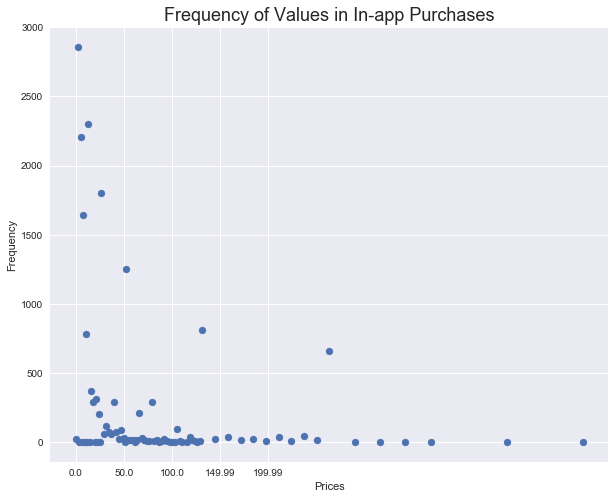

In [58]:
#plot of in-app purchase prices and their frequencies
plt.figure(figsize=(10,8))
plt.scatter(iapdict.keys(),iapdict.values())

pts = 18 #font pt size

plt.rc('axes', titlesize=pts, labelsize=pts)     # font size of the axes titles and labels
plt.rc('xtick', labelsize=pts)    # font size of the tick labels
plt.rc('ytick', labelsize=pts)    # font size of the tick labels
plt.rc('figure', titlesize=pts+2) #title font size, slightly larger than the other text
    
plt.ylabel('Frequency')
plt.xlabel('Prices')
plt.title(f'Frequency of Values in In-app Purchases')

xaxislist=[0]*5#5 values and ticks total, 0 to 199.99
for i in range(0,5):
    xaxislist[i]=round((199.99/4)*i,2) #dividing by 4 and multiplying by 0 1 2 3 4 to get the appropriate value
plt.xticks(range(0,77,19),xaxislist) #19 x 4 = 76, so the range gives 0 19 38 57 76

plt.show()

The original plot had 77 ticks numbered from 0 to 76 along the x-axis and looked cluttered, so I used 5 ticks (4, a factor of 76, plus 1) and divided up the range of 0 to 199.99, inclusive, at evenly-spaced intervals.

In order, the six most common prices are .99, 4.99, 1.99, 9.99, 2.99, and 19.99, all but one of which are under 10.
The boundaries for buckets I propose are:
1. 0 or null
2. 0.49 to 0.99 (the smallest nonzero price is 0.49)
3. 1.49 to 1.99
4. 2.49 to 19.49
5. 19.99 to 48.99
6. 49.99 to 199.99

In [59]:
#creating a list of the bucket boundaries to cover all possible values in In-app Purchases
iap_bins = [0,.99,1.99,19.49,48.99,199.99]

### Creating Dummy Dataframes for Categorical Data

In [60]:
#putting the proposed bins for In-app Purchases into the form of a function
def findcol(amt, bounds=[0,.99,1.99,19.49,48.99,199.99]): #amt is a float or a format that can be converted to a float
    '''
    A function specific to the In-App Purchases data to determine which bin a number falls in.
    It returns the value of the upper bound as a String or the String "none" if amt is 0.
    
    Args
        amt (float or can be converted) : a positive number that can be converted to a float, falling between 0 and the 
                                            last item in bounds, inclusive.
        bounds (index-able arraylike of floats or ints) : a series of six numbers in ascending order starting at 0 to serve
                                                            as buckets
    Returns:
        (str) : the upper bound of the two numbers amt fell between, inclusive of the upper, exclusive of the lower; 
                or "none" if amt=0
    '''
    amt = float(amt)
    
    if amt==0:
        return "none"
    elif amt<=bounds[1]:
        return str(bounds[1])
    elif amt<=bounds[2]:
        return str(bounds[2])
    elif amt<=bounds[3]:
        return str(bounds[3])
    elif amt<=bounds[4]:
        return str(bounds[4])
    else: # amt>bounds[4]
        return str(bounds[5])

In [61]:
#create dataframe solely of one categorical variable
def dummydf(myindex,myseries,prefix,isprices=False,bins=True): #prefix for all columns in new dataframe
    '''
    Creates a pandas dataframe using the items in myseries to create binary columns (1 or NaN), assuming each item is
    a String containing multiple values separated by commas. If the item contains a particular value, the resulting
    dataframe has a column titled in the format prefix_value with a 1 at the corresponding index. Otherwise, the location
    will be NaN.
    
    Args
        myindex (pandas DataFrame Index) : the desired index values that correspond to myseries and the returned DataFrame
        myseries (pandas Series) : a Series with the same length as myindex consisting of Strings of numbers or chars
                                    to become columns
        prefix (str) : the preferred prefix to be used for all of the columns of the returned DataFrame
        isprices (boolean) : defaults to False.  If True, myseries entries NaN values are treated the same as 0.00 values
        bins (boolean) : defaults to True, only used if isprices is True. Then, myseries is sorted into the default bins of
                        the findcol function.
    
    Returns
        (pandas DataFrame) : a dataframe containing only NaN's and 1's, with as many columns as unique values in 
                            myseries' data, once split by comma.  If isprices=True, there are six columns with "_none"
                            being where a 1 indicates whether a record has null or only 0 for myseries. Records containing
                            0 and nonzero values such as "0.00, 0.99, 9.99" will have NaN in the "_none" column.
    '''
    mydf = emptyframe(myindex)
    for idx, values in zip(myindex,myseries):
        try:
            length = len(values)
        except: #if there are no in-app purchases (null value)
            mydf.loc[idx,prefix+"_none"] = 1
            continue
        if isprices: #if the column is each value is a list of prices to be sorted by the default bounds in findcol
            if bins:#if the data will be sorted into bins
                method = findcol #use findcol function
            else:
                method = str #otherwise, simply convert the number to a String
                
            plist = values.split(",") #split prices by comma
            pfloats = set([float(pl) for pl in plist])#convert all to floats and into a set so that there is only one of 
                                                        #each price in the list
            if len(pfloats)==1:#if there is now only one item in the list
                for p in pfloats:#sets do not support indexing, but I can access the lone element with a loop
                    if p == 0:
                        colname = prefix+"_none"#the only in-app purchases are free, equivalent to having none
                    else:
                        colname= prefix+"_"+method(p) #or findcol, for bins
                    mydf.loc[idx, colname] = 1
                    continue
            else: #if the set has more than one item
                for p in pfloats:
                    if p == 0: #if it has in-app purchases other than 0.0, then it can not be also in the iap_none column
                        continue
                    else:
                        colname = prefix+"_"+method(p)#str, or findcol for bins
                        mydf.loc[idx, colname] = 1
        else: #myseries' values's are not lists of prices
        #a try-exception for if there are no commas
            try:
                vlist = values.split(",") #split strings by comma
            except: #assume, if split doesn't work, values has only one item listed
                vlist = values.strip().lower()
                colname=prefix+"_"+v
                mydf.loc[idx, colname] = 1
                continue
            #remove trailing and leading spaces, lowercase, put into a set so that there is only one of each type
            vset = set([vl.strip().lower() for vl in vlist])

            for v in vset:#sets do not support indexing, but can access elements with a loop
                colname=prefix+"_"+v
                mydf.loc[idx, colname] = 1
    return mydf.drop(columns=[1])

In [62]:
langdf = dummydf(edadf.index,edadf["Languages"],"lang")
langdf.head()

,lang_ko,lang_nl,lang_ja,lang_pl,lang_it,lang_pt,lang_sv,lang_en,lang_fr,lang_nb,...,lang_ug,lang_eo,lang_rw,lang_ti,lang_gd,lang_qu,lang_om,lang_or,lang_mg,lang_yi
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
genredf = dummydf(edadf.index,edadf["Genres"],"genr")
genredf.tail()

,genr_puzzle,genr_games,genr_strategy,genr_board,genr_education,genr_entertainment,genr_casual,genr_action,genr_card,genr_simulation,...,genr_food & drink,genr_news,genr_photo & video,genr_emoji & expressions,genr_stickers,genr_gaming,genr_shopping,genr_kids & family,genr_weather,genr_magazines & newspapers
16950,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16956,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16962,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16967,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16993,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
iapdf = dummydf(edadf.index,edadf["In-app Purchases"],"iap",True,bins=False)
iapdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 76 columns):
iap_none      2896 non-null float64
iap_1.99      2208 non-null float64
iap_0.99      2860 non-null float64
iap_4.99      2302 non-null float64
iap_2.99      1640 non-null float64
iap_5.99      372 non-null float64
iap_9.99      1804 non-null float64
iap_99.99     661 non-null float64
iap_5.49      4 non-null float64
iap_36.99     2 non-null float64
iap_13.99     56 non-null float64
iap_49.99     811 non-null float64
iap_19.99     1255 non-null float64
iap_23.49     1 non-null float64
iap_29.99     287 non-null float64
iap_7.99      314 non-null float64
iap_3.99      783 non-null float64
iap_6.99      289 non-null float64
iap_14.99     287 non-null float64
iap_34.99     26 non-null float64
iap_24.99     209 non-null float64
iap_8.49      2 non-null float64
iap_37.99     4 non-null float64
iap_199.99    2 non-null float64
iap_11.99     115 non-null float64
iap_15.99     75 non-nul

In [65]:
binsiapdf = dummydf(edadf.index,edadf["In-app Purchases"],"iapb",True,bins=True)
binsiapdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 6 columns):
iapb_none      2896 non-null float64
iapb_1.99      2209 non-null float64
iapb_0.99      2860 non-null float64
iapb_19.49     3579 non-null float64
iapb_199.99    1080 non-null float64
iapb_48.99     1730 non-null float64
dtypes: float64(6)
memory usage: 728.2 KB


The `binsiapdf` has a more even distribution, but even then, the two-highest bins could be combined to still be less than the $0.99$ and $19.49$ bins, the latter of which appears in almost half of all records.

In [66]:
#save both as CSV files to resume work with later
iapdf.to_csv("files/iap7464.csv")
binsiapdf.to_csv("files/binsiap7464.csv")

### Converting Age Rating with `get_dummies`
`Age Rating` is a more straightforward column of Strings, with four possibilities (no records have null values in it), of which no record can have more than one.  A game rated 4+ will not also have the rating 12+ although it is true that a game rated 4+ is suitable for anyone 4 and older, including those users 12 and older.  One rating suffices for each record (no lists like `Languages`) so it's simple to use `pandas.get_dummies` to create a dummy dataframe.

In [67]:
#see the percentage of values in Age Rating
edadf["Age Rating"].value_counts(normalize=True)

4+     0.590836
9+     0.193998
12+    0.176715
17+    0.038451
Name: Age Rating, dtype: float64

In [68]:
#convert Age Rating to category type, then use get_dummies
edadf["Age Rating"]=edadf["Age Rating"].astype('category')
ageRatingdf = pd.get_dummies(edadf["Age Rating"])
ageRatingdf.set_index(edadf.index)
ageRatingdf.tail()

Age Rating,12+,17+,4+,9+
16950,1,0,0,0
16956,0,0,1,0
16962,0,0,0,1
16967,0,0,1,0
16993,0,0,1,0


### Dates Conversion, Creating Binary Categorical and Length of Text Numerical Columns
The next several cells create a dataframe with converting other variables from text to a numerical value as follows:

- Description $\rightarrow$ DescripLength: the length of the text in the app's description
- Name $\rightarrow$ NameLength: the length of the app's name
- Subtitle $\rightarrow$ HasSubtitle: whether the `Subtitle` for that record is null ($1$ if it has a subtitle)
- Current Version Release Date $\rightarrow$ UpToDate : $1$ if the app's latest release was within the six months prior to the latest Original Release Date of the `edadf` version of the dataset
- Average User Rating $\rightarrow$ Target : $1$ is the rating is 4.5 or above, $0$ if 4 or lower

In [69]:
#convert Date columns into pandas datetime format
edadf["Original Release Date"] = pd.to_datetime(edadf["Original Release Date"])
edadf["Current Version Release Date"] = pd.to_datetime(edadf["Current Version Release Date"])

In [70]:
#considering the dates for when the apps were first released
origRel = edadf["Original Release Date"]
origRel[-5:]

16950   2019-07-31
16956   2019-07-23
16962   2019-07-31
16967   2019-07-28
16993   2019-07-30
Name: Original Release Date, dtype: datetime64[ns]

In [71]:
#the most recent release of the whole dataset
sortOrig = origRel.sort_values(ascending=True)
sortOrig.tail()

16451   2019-12-04
16096   2019-12-05
16589   2019-12-05
15257   2019-12-06
16355   2019-12-06
Name: Original Release Date, dtype: datetime64[ns]

In [72]:
earliest = pd.to_datetime(sortOrig[0:1].values[0])
latest = pd.to_datetime(sortOrig[-1:].values[0])

In [73]:
#seeing the earliest and latest dates for Original Release
print("The dates range from {} to {}.".format(earliest,latest))

The dates range from 2008-01-08 00:00:00 to 2019-12-06 00:00:00.


In [74]:
#create empty dataframe to store binary categorical columns and length of Strings columns
columnNames =["NameLength","HasSubtitle","DescripLength","UpToDate","Target"]
placedf = pd.DataFrame(data=np.nan,columns=columnNames,index=edadf.index)
placedf.head(2)

,NameLength,HasSubtitle,DescripLength,UpToDate,Target
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


In [75]:
edadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 18 columns):
URL                             7464 non-null object
ID                              7464 non-null int64
Name                            7464 non-null object
Subtitle                        2689 non-null object
Icon URL                        7464 non-null object
Average User Rating             7464 non-null float64
User Rating Count               7464 non-null float64
Price                           7464 non-null float64
In-app Purchases                4573 non-null object
Description                     7464 non-null object
Developer                       7464 non-null object
Age Rating                      7464 non-null category
Languages                       7464 non-null object
Size                            7464 non-null float64
Primary Genre                   7464 non-null object
Genres                          7464 non-null object
Original Release Date           7464 no

In [76]:
#creating categorical and numerical variables: "Target", "NameLength", "HasSubtitle","DescripLength","UpToDate"

#the latest Original Release Date was 2019-12-06, so six months before is 2019-06-06
halfYearAgo = latest - pd.DateOffset(months=6)

for idx,row in zip(edadf.index,edadf.values):#loop through by row of edadf
    try: #whether the Subtitle value is null
        sublen = len(row[3])
        if (sublen>0):
            placedf.loc[idx,"HasSubtitle"] = 1
    except:#if it is null, HasSubtitle is 0
        placedf.loc[idx,"HasSubtitle"] = 0
        
    curRelease = row[17]#the time code for the Current Version Release Date (date last updated)
    if curRelease>halfYearAgo: #if between 2019-06-06 and 2019-12-06
        placedf.loc[idx,"UpToDate"] = 1
    
    #adding data to the columns for the length of characters in the Name and Description
    placedf.loc[idx,"NameLength"] = len(row[2])
    placedf.loc[idx,"DescripLength"] = len(row[9])
    
    #the target column is 1 for 4.5 or more, 0 is 4.0 or lower
    if row[5]>=4.5:
        placedf.loc[idx,"Target"] = 1

In [77]:
placedf.tail()

,NameLength,HasSubtitle,DescripLength,UpToDate,Target
16950,8.0,1.0,547.0,1.0,NaN
16956,11.0,0.0,102.0,1.0,1.0
16962,18.0,1.0,134.0,1.0,1.0
16967,18.0,1.0,722.0,1.0,1.0
16993,21.0,1.0,257.0,1.0,1.0


The new DataFrame `placedf` looks as expected.  The remaining null values can be filled in with 0's.

### Combining all previously-created dummy dataframes with numeric and categorical data

In [78]:
#fill in all NaN values with 0
for eachdf in [placedf,langdf,iapdf,genredf,binsiapdf]:
    eachdf.fillna(value=0,inplace=True)
    print(eachdf.shape)

(7464, 5)
(7464, 113)
(7464, 76)
(7464, 41)
(7464, 6)


The resulting shapes for each are as expected; 7464 rows in each.

In [79]:
edadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 18 columns):
URL                             7464 non-null object
ID                              7464 non-null int64
Name                            7464 non-null object
Subtitle                        2689 non-null object
Icon URL                        7464 non-null object
Average User Rating             7464 non-null float64
User Rating Count               7464 non-null float64
Price                           7464 non-null float64
In-app Purchases                4573 non-null object
Description                     7464 non-null object
Developer                       7464 non-null object
Age Rating                      7464 non-null category
Languages                       7464 non-null object
Size                            7464 non-null float64
Primary Genre                   7464 non-null object
Genres                          7464 non-null object
Original Release Date           7464 no

The numerical features are `ID`, `Average User Rating`, `User Rating Count`, `Price`, and `Size`.  `Average User Rating` was already turned into `Target` and `ID` is ostensibly a categorical variable that contains little information as it pertains to this project's modeling question.  As such, the other three features will be included in the model as-is.

In [80]:
#taking the already numerical features from the DataFrame edadf
#except Average User Rating, which became Target, and ID, which is a categorical variable at heart
restdf = edadf[["User Rating Count","Price","Size"]]
restdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 3 columns):
User Rating Count    7464 non-null float64
Price                7464 non-null float64
Size                 7464 non-null float64
dtypes: float64(3)
memory usage: 553.2 KB


In [81]:
#concatenate restdf together with the IsCompany column from devcodf and the dummy ageRatingdf
restdf = pd.concat([restdf,devcodf.IsCompany,ageRatingdf],axis=1)
restdf.head(10)

,User Rating Count,Price,Size,IsCompany,12+,17+,4+,9+
0,3553.0,2.99,15853568.0,0,0,0,1,0
1,284.0,1.99,12328960.0,0,0,0,1,0
2,8376.0,0.00,674816.0,0,0,0,1,0
3,190394.0,0.00,21552128.0,0,0,0,1,0
4,28.0,2.99,34689024.0,0,0,0,1,0
5,47.0,0.00,48672768.0,1,0,0,1,0
7,125.0,0.99,64333824.0,0,0,0,1,0
8,44.0,0.00,2657280.0,0,0,0,1,0
9,184.0,0.00,1466515.0,0,0,0,1,0
11,5072.0,0.00,7086403.0,0,0,0,1,0


In [82]:
#concatentate all dataframes' features
dectreedf = pd.concat([placedf,iapdf,langdf,genredf,restdf],axis=1)#with the non-binned version of In-app Purchases
dectreedf.head()

,NameLength,HasSubtitle,DescripLength,UpToDate,Target,iap_none,iap_1.99,iap_0.99,iap_4.99,iap_2.99,...,genr_weather,genr_magazines & newspapers,User Rating Count,Price,Size,IsCompany,12+,17+,4+,9+
0,6.0,0.0,1617.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3553.0,2.99,15853568.0,0,0,0,1,0
1,7.0,0.0,1222.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,284.0,1.99,12328960.0,0,0,0,1,0
2,7.0,0.0,582.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8376.0,0.00,674816.0,0,0,0,1,0
3,13.0,0.0,1675.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,190394.0,0.00,21552128.0,0,0,0,1,0
4,12.0,0.0,2076.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,28.0,2.99,34689024.0,0,0,0,1,0


In [83]:
dectreebinsdf = pd.concat([placedf,binsiapdf,langdf,genredf,restdf],axis=1)#with bins for In-app Purchases
dectreebinsdf.tail()

,NameLength,HasSubtitle,DescripLength,UpToDate,Target,iapb_none,iapb_1.99,iapb_0.99,iapb_19.49,iapb_199.99,...,genr_weather,genr_magazines & newspapers,User Rating Count,Price,Size,IsCompany,12+,17+,4+,9+
16950,8.0,1.0,547.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,151308288.0,0,1,0,0,0
16956,11.0,0.0,102.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,0.0,79646720.0,0,0,0,1,0
16962,18.0,1.0,134.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,51.0,0.0,125348864.0,0,0,0,0,1
16967,18.0,1.0,722.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,128687104.0,0,0,0,1,0
16993,21.0,1.0,257.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.0,0.0,8845312.0,0,0,0,1,0


In [84]:
#saving these combined dataframes for later use in preliminary modeling
dectreedf.to_csv("files/temp7464.csv")
dectreebinsdf.to_csv("files/tempbins7464.csv")

In [85]:
#checking whether any values are null
print("The dataframe has {} null values and a shape of {}.".format(dectreedf.isna().sum().sum(),dectreedf.shape))
print("The binned dataframe has {} null values and a shape of {}.".format(dectreebinsdf.isna().sum().sum(),
                                                                          dectreebinsdf.shape))

The dataframe has 0 null values and a shape of (7464, 243).
The binned dataframe has 0 null values and a shape of (7464, 173).


This meets expectations, as any NaN values created from the `dummydf` function have been filled in with 0 and the indices for all of the dataframes are the same as those of `edadf`.

In [86]:
dectreedf.describe()

,NameLength,HasSubtitle,DescripLength,UpToDate,Target,iap_none,iap_1.99,iap_0.99,iap_4.99,iap_2.99,...,genr_weather,genr_magazines & newspapers,User Rating Count,Price,Size,IsCompany,12+,17+,4+,9+
count,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,...,7464.000000,7464.000000,7.464000e+03,7464.000000,7.464000e+03,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000
mean,23.552921,0.360263,1337.098875,0.144695,0.509512,0.387996,0.295820,0.383173,0.308414,0.219721,...,0.000134,0.000134,3.314929e+03,0.570717,1.514538e+08,0.259378,0.176715,0.038451,0.590836,0.193998
std,14.942935,0.480109,967.395618,0.351816,0.499943,0.487326,0.456441,0.486192,0.461869,0.414086,...,0.011575,0.011575,4.258374e+04,2.425675,2.560096e+08,0.438323,0.381453,0.192296,0.491713,0.395454
min,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000e+00,0.000000,2.158400e+05,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.200000e+01,0.000000,3.053773e+07,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,0.000000,1134.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.600000e+01,0.000000,7.926989e+07,0.000000,0.000000,0.000000,1.000000,0.000000
75%,29.000000,1.000000,1812.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,3.080000e+02,0.000000,1.772618e+08,1.000000,0.000000,0.000000,1.000000,0.000000
max,251.000000,1.000000,12494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,3.032734e+06,139.990000,4.005591e+09,1.000000,1.000000,1.000000,1.000000,1.000000


For categorical variables where the values in the features are either 1 or 0, the mean in `.describe()` can be easily converted to a percentage of 1's. From the table, it can be seen that `Target` consists of 50.95% 1 values and `UpToDate` has 14.47%, while `genr_weather` has 0.01% (one-hundredth of a percent) and `17+` is at 3.84%.

Interestingly, the average `Price` is 0.57 with a standard deviation of 2.43, and the 1st, 2nd and 3rd quartiles are 0.

#### Method to create a column of miscellaneous values
Where categorical variables have only a few records in that category, could look for different results after combining those categories with $x$ or fewer records into one category of "etc."

In [87]:
def combine(dataframe,prefix,threshold=100):
    '''
    Creates new column based on whether a value of the provided dataframe is 1 for each column that contains fewer 
    than the provided or default number of non-null entries.
    
    Args
        dataframe (pandas DataFrame) : the 1's in the dataframe indicate which values to be collected into the new column
        prefix (str) : a desired prefix for the column to be added; the column will be named prefix_etc
        threshold (int) : defaults to 100; the values that are 1 in a column containing fewer non-null entries 
                        than threshold will be noted with a 1 at the same index in the prefix_etc column
    
    Returns
        dataframe (pandas DataFrame) : dataframe with an additional column at the end named after the provided prefix 
                                    (prefix_etc), a column containing 1's at the indices where entries were 1 in an 
                                    original column that did not meet the threshold for non-null entries, and null (np.nan) 
                                    values otherwise
        colcombine (list) : column names that were combined into the dataframe
    '''
    #combine those with fewer than 100 entries into another column: [prefix]_etc
    colcombine=[]
    hold=len(dataframe.index)-threshold #so a column would need to have more than 7437 NaN values (assuming 7537 total)
    for colname in dataframe.columns:
        totalnull = dataframe[colname].isna().sum() #finding how many NaN entries in a column
        if totalnull > hold: #if the column has more than 7437 NaN values
            colcombine.append(colname)
        else:
            continue

    dataframe[prefix+"_etc"] = np.nan#create new column initialized with NaN 

    for idx,row in zip(dataframe.index,dataframe.values):#to loop row by row
        for col in colcombine:#for each column with fewer than threshold records
            try:
                if(dataframe.loc[idx,col]==1):
                    dataframe.loc[idx,prefix+"_etc"]=1 #sets that index position in [prefix]_etc as 1
            except:#if the location is null, go to next column in colcombine
                continue
    
    return dataframe, colcombine #returns modified dataframe and list of columns that were combined into prefix_etc

In this final Notebook, I did not end up using the above method, but thought others could find it useful for their own modeling with this data.

### Stacked Bar Charts for Categorical Data

In [88]:
def barPercentages(dataframe, targetdf):
    '''
    Find percentages for each column in dataframe based on each of the record's corresponding value in targetdf.
    
    Args
        dataframe (pandas DataFrame or Series) : a DataFrame or Series where a 1 indicates the feature described by each 
                                                column name is present for that record
        targetdf (pandas Series) : a value of 1 means that the record at that index matches the target
    
    Returns
        positarget (list) : a list of floats as percentages for how much of each column in dataframe meets the target and
                            has that feature
        falstarget (list) : a list of floats as percentages for how much of each column in dataframe does not match the
                            target and has that feature
    '''
    positarget=[]
    falstarget = []
    try:
        cols = dataframe.columns
    except:
        dataframe = dataframe.to_frame() #if no .columns, can convert Series to DataFrame
            
    for colname in dataframe.columns:#iterate over each "dummy" column
        total = sum(dataframe[colname])
        
        #filter a column to get the indices that have value of 1 in that column
        indices = dataframe.loc[dataframe[colname]>0].index #the index from the dataframe where colname's values are 1
        targetSeries = targetdf[indices] #filtering target by selected indices
        allTrue = sum(targetSeries) #adding up all values (all records are 0 or 1) so allTrue is number of 1's
        if total != 0:
            percent =  allTrue/total*100
            falsepercent = (total-allTrue)/total*100 #both percentages are from dividing by total as long as it's nonzero
        else:
            percent = 0 #if there are no values in a selected column, then there is no percentage
            falsepercent=0
            
        positarget.append(percent) #there are no null values; just 0 if there were only 0's in dataframe's colname
        falstarget.append(falsepercent)
        
    return positarget, falstarget

In [89]:
#function to graph stacked bar charts
def stackedbarchart(featuredf,binarytarget,dummyname,barwidth=0.3):
    '''
    Plots stacked bar charts created by comparing the columns given by featuredf to the binarytarget.  All records that 
        possess a feature (represented by a 1 in that column) have percentages taken of whether they match binarytarget
        (if the value at the same index is 1). Each bar is split into these two percentages and the graph also has a 
        horizontal black line at 51, which is the binarytarget ratio across the entire dataset (51% are 1, 49% are 0). 
        Each bar has the percentage of positive for the target on the bottom and negative for the target on the top part.
    
    Args
        featuredf (pandas DataFrame) : a dataframe of dummy columns (features of 1's and 0's only) with the same indices 
                                    as binarytarget, to be plotted
        binarytarget (pandas Series) : the target with the same indices as featuredf, in 1's and 0's only, against which 
                                    to compare the data in featuredf
        dummyname (str) : the name of the categorical variable that was turned into the dummy columns making up featuredf 
                        or the desired noun(s) to fil in the title of the plot (Percentages of Ratings by dummyname)
        barwidth (float or int) : defaults to 0.3
    
    Returns
        displays a plot of the stacked bar graph
    '''
    #each of the two groups becomes an array-like of values
    N = len(featuredf.columns) #number of variables/features
    ind = np.arange(N) #locations on the x-axis for each feature

    yesTarget, notTarget = barPercentages(featuredf,binarytarget)
    
    colors = [["darkred","brown"],["gray","darkgray"]]
    
    plt.figure(figsize=(20,10))
    bars1 = plt.bar(ind, yesTarget, barwidth, color=colors[0]) #alternating colors
    bars2 = plt.bar(ind, notTarget, barwidth, bottom=yesTarget, color=colors[1])

    plt.axhline(51,color="k")

    pts = 18 #font pt size

    plt.rc('axes', titlesize=pts, labelsize=pts)     # font size of the axes titles and labels
    plt.rc('xtick', labelsize=pts)    # font size of the tick labels
    plt.rc('ytick', labelsize=pts)    # font size of the tick labels
    plt.rc('figure', titlesize=pts+2) #title font size, slightly larger than the other text
    
    plt.ylabel('Percentages')
    plt.title(f'Percentages of Ratings by {dummyname}')
    plt.xticks(ind, featuredf.columns)
    plt.legend((bars1[0], bars2[0]), ('4.5- or 5-rated', '4 or lower-rated'))#assuming binarytarget is from User Ratings
    plt.show()

## Using a Random Forest Classifier to Find Important Features

In [90]:
def baseclassifier(data,target):
    '''
    This function fits a DecisionTreeClassifier to data and target, having been created with 'gini' criterion and 
    max_depth of 5.  Its feature_importances_ are then graphed with data.columns as the feature names.
    
    Args
        data (pandas DataFrame) : a pandas DataFrame containing the data to be fit to the classifier with target
        target (pandas Series) : a pandas series of containing the value predicted by data
    
    Returns
        clf (DecisionTreeClassifier) : a classifier with criterion='gini' and max_depth=5 fitted to data and target
    '''
    clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
    clf.fit(data, target)
    
    return clf

In [91]:
def importantfeatures(classifier, featnames,plot=True):
    '''
    This function takes in a fitted classifier and the labels that were used to create it to return a list of those labels
    that had feature_importances_ greater than 0.
    
    Args
        classifier (DecisionTreeClassifier) : a fitted classifier, from Sci-Kit Learn, with the attribute 
                                                feature_importances_
        featnames (arraylike) : list or arraylike of feature names used in the classifier, the order and length matches 
                                classifier's feature_importances_
        plot (boolean) : defaults to True, whether to plot a bar graph of the feature_importances_
        
    Returns
        imporfeats (dict) : names of those features with classifier.feature_importances_ greater than 0 as the keys and 
                            importance as the values
        Prints imporfeats and their corresponding importances
        Displays a horizontal bar graph of feature importance, using the featnames as the y-axis "Feature name"
    '''
#loop through to find the names of the most important features
    nfeatures = len(featnames)
    imporfeats = dict()#a list to store the column names of the more important features
    if plot:
        imporindex = [0]#creating list of values for yticks
        ylabels = []#creating complimentary list of labels for the y-axis
    i=0
    for feature, importance in zip(featnames,classifier.feature_importances_):
        if importance>0:
            print(feature,importance)
            imporfeats[feature]=importance
            if plot:
                ylabels.append(feature)
                if i !=0 and i!=(nfeatures-1):
                    imporindex.append(i)
        elif plot and (i ==0 or i==(nfeatures-1)):#to be sure the labels match up correctly with the tick mark values
            ylabels.append("")
        
        i+=1 #increment counter
    #end for loop
    
    if plot:
        imporindex.append(nfeatures-1)#last tick mark place
        #begin plot of feature importance
        plt.figure(figsize=(8,8))
        plt.barh(range(nfeatures), classifier.feature_importances_, align='center')#horizontal bar plot with importances 
                                                                                    #on the x-axis
        plt.yticks(imporindex,ylabels,fontsize=12)#feature names (labels) on the y-axis
        plt.xlabel('Feature importance')
        plt.ylabel('Feature name')
    
    return imporfeats

In [92]:
def importantframe(dataframe):
    '''
    Makes a Pandas DataFrame containing the features that had feature_importances_ over 0 and dataframe's Target after 
    fitting a criterion='gini', max_depth=5 DecisionTreeClassifier.  The features and their importances are plotted on a 
    horizontal bar graph.
    
    Args
        dataframe (Pandas DataFrame) : data from which to determine which features are important, with target stored in 
                                        column "Target"
            
    Returns
        clsfr (DecisionTreeClassifier) : with parameters max_depth=5 and criterion="gini", has been fitted to dataframe
        newframe (Pandas DataFrame) : dataframe of only the important features (that the classifier found to have values 
                                        for feature_importances_ more than 0)
        Prints important features and their corresponding importances.
        Plots horizontal bar plot with clsfr.feature_importances_ on the x-axis and dataframe.columns (except Target) on 
            the y-axis.  
    '''
    y = dataframe.Target #creates X and y from the given dataframe
    X = dataframe.drop(columns="Target")
    clsfr = baseclassifier(X,y) #fits a decision tree classifier with max_depth=5 and 'gini' criterion
    
    imporfeats = importantfeatures(clsfr, X.columns) #gets the features that had values over 0 for feature_importances_
    newfeatures = [k for k in imporfeats.keys()]
    newframe = pd.concat([dataframe[newfeatures],dataframe["Target"]],axis=1) #creates new dataframe using only those 
                                                                                #important columns and the Target column
    return clsfr, newframe

In [93]:
dectreedf = getData("files/temp7464.csv")
dectreebinsdf = getData("files/tempbins7464.csv")

In [94]:
dectreedf.describe()

,NameLength,HasSubtitle,DescripLength,UpToDate,Target,iap_none,iap_1.99,iap_0.99,iap_4.99,iap_2.99,...,genr_weather,genr_magazines & newspapers,User Rating Count,Price,Size,IsCompany,12+,17+,4+,9+
count,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,...,7464.000000,7464.000000,7.464000e+03,7464.000000,7.464000e+03,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000
mean,23.552921,0.360263,1337.098875,0.144695,0.509512,0.387996,0.295820,0.383173,0.308414,0.219721,...,0.000134,0.000134,3.314929e+03,0.570717,1.514538e+08,0.259378,0.176715,0.038451,0.590836,0.193998
std,14.942935,0.480109,967.395618,0.351816,0.499943,0.487326,0.456441,0.486192,0.461869,0.414086,...,0.011575,0.011575,4.258374e+04,2.425675,2.560096e+08,0.438323,0.381453,0.192296,0.491713,0.395454
min,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000e+00,0.000000,2.158400e+05,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.200000e+01,0.000000,3.053773e+07,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,0.000000,1134.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.600000e+01,0.000000,7.926989e+07,0.000000,0.000000,0.000000,1.000000,0.000000
75%,29.000000,1.000000,1812.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,3.080000e+02,0.000000,1.772618e+08,1.000000,0.000000,0.000000,1.000000,0.000000
max,251.000000,1.000000,12494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,3.032734e+06,139.990000,4.005591e+09,1.000000,1.000000,1.000000,1.000000,1.000000


NameLength 0.022330635648788528
HasSubtitle 0.2793231707813555
DescripLength 0.08272762956891218
iap_none 0.002818770223266262
iap_1.99 0.028339862229282864
iap_0.99 0.006201294491185778
iap_29.99 0.01890548163004876
lang_ja 0.018985336667571698
lang_gu 0.005983459180399363
genr_entertainment 0.02091553519930648
genr_casual 0.03290838528663342
genr_simulation 0.04773184857131644
User Rating Count 0.31239363689173977
Size 0.12043495363019303
NameLength 0.022537061991685977
HasSubtitle 0.2819052585256443
DescripLength 0.08349237098949114
iapb_none 0.0028448271809726434
iapb_1.99 0.028601838386621937
iapb_0.99 0.006258619798139817
iapb_19.49 0.011953178569926271
lang_ja 0.019160838775017366
lang_gu 0.0060387707987479
genr_entertainment 0.02110888023026936
genr_casual 0.03321259326943433
genr_simulation 0.04817308594114681
User Rating Count 0.3042687409219296
Size 0.13044393462097273


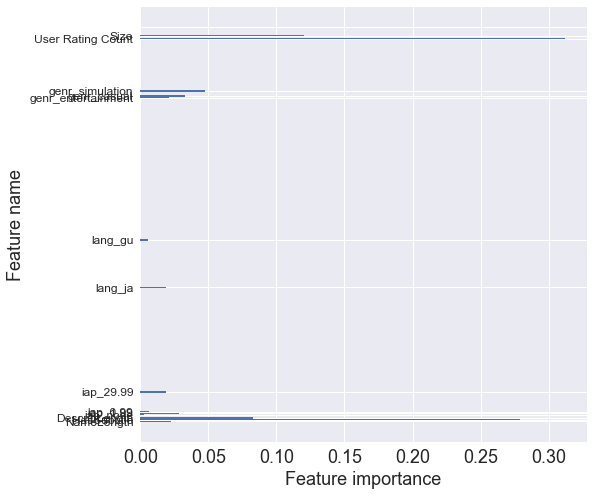

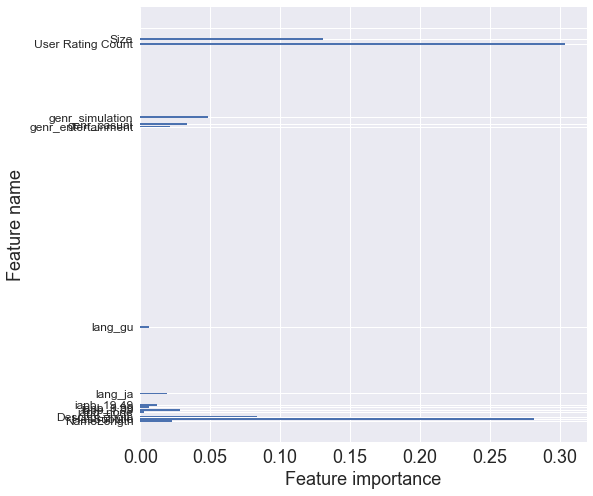

In [95]:
#find important features and plot them
dectree, finaldf = importantframe(dectreedf)
dectreebins, finalbinsdf = importantframe(dectreebinsdf)

Some features really stand out, while a majority barely appear on the plot.  The highest-valued features (with bins and without) are User Rating Count (0.30 and 0.31), HasSubtitle (0.28 for both), Size (0.13 and 0.12) and DescripLength (0.08 for both).  The rest have `feature_importances_` below 0.05.
The differences between the version with the binned In-app Purchases and the version without bins are very slight.  Really, the important features are the same, except for two.

One different pair was the bin `iapb_19.49` (0.012) and the categorical `iap_29.99` (0.019).  The other was `lang_ml` for the In-app Purchases without bins and `lang_gu` for the binned version (both 0.006).

The bins were separated by which prices were less than or equal to the number in the column name.  So the bins' ranges are as follows (as defined earlier in this notebook, notably the `bounds` argument in the `findcol` function):
1. 0 or null
2. 0.49 to 0.99
3. 1.49 to 1.99
4. 2.49 to 19.49
5. 19.99 to 48.99
6. 49.99 to 199.99

The preserved bins were `iapb_none`, `iapb_1.99`, `iapb_0.99` and `iapb_19.49` while the classifier used on the other dataframe kept `iap_none`, `iap_1.99`, `iap_0.99` and `iap_29.99`.
For both, "none" is the same.  Those records with In-app Purchases of 1.99 and 0.99 would also match up with that bin.  However, a record with 29.99 would be included in the `iapb_48.99` so that is interesting that the bin of 2.49-19.49 is important while the 19.99-48.99 is not although the price 29.99 is important in the non-binned In-app Purchases.
The values of `feature_importances_` are very small, so I suspect the combined importance of the values between 2.49 and 19.49 is enough to edge out the importance of 29.99 as part of 19.99-48.99 in the binned version of the dataframe.

As for the languages, `lang_ml` and `lang_gu` are the least important of the fourteen features for both, so the difference must be incredibly slight.

Of those with values over 0 in `feature_importances_`, the highest-performing are `User Rating Count` and `HasSubtitle`, followed by `Size` and `DescripLength`.

In [96]:
#important features for the version where In-app Purchases is not in bins
finalfeats = importantfeatures(dectree,dectreedf.drop(columns=["Target"]).columns,plot=False)
finalfeats.keys()

NameLength 0.022330635648788528
HasSubtitle 0.2793231707813555
DescripLength 0.08272762956891218
iap_none 0.002818770223266262
iap_1.99 0.028339862229282864
iap_0.99 0.006201294491185778
iap_29.99 0.01890548163004876
lang_ja 0.018985336667571698
lang_gu 0.005983459180399363
genr_entertainment 0.02091553519930648
genr_casual 0.03290838528663342
genr_simulation 0.04773184857131644
User Rating Count 0.31239363689173977
Size 0.12043495363019303


dict_keys(['NameLength', 'HasSubtitle', 'DescripLength', 'iap_none', 'iap_1.99', 'iap_0.99', 'iap_29.99', 'lang_ja', 'lang_gu', 'genr_entertainment', 'genr_casual', 'genr_simulation', 'User Rating Count', 'Size'])

In [97]:
#important fetaures for the version where In-app Purchases is binned
finalbinsfeats = importantfeatures(dectreebins,dectreebinsdf.drop(columns=["Target"]).columns,plot=False)
finalbinsfeats.keys()

NameLength 0.022537061991685977
HasSubtitle 0.2819052585256443
DescripLength 0.08349237098949114
iapb_none 0.0028448271809726434
iapb_1.99 0.028601838386621937
iapb_0.99 0.006258619798139817
iapb_19.49 0.011953178569926271
lang_ja 0.019160838775017366
lang_gu 0.0060387707987479
genr_entertainment 0.02110888023026936
genr_casual 0.03321259326943433
genr_simulation 0.04817308594114681
User Rating Count 0.3042687409219296
Size 0.13044393462097273


dict_keys(['NameLength', 'HasSubtitle', 'DescripLength', 'iapb_none', 'iapb_1.99', 'iapb_0.99', 'iapb_19.49', 'lang_ja', 'lang_gu', 'genr_entertainment', 'genr_casual', 'genr_simulation', 'User Rating Count', 'Size'])

In [98]:
importantfeats = ['NameLength', 'HasSubtitle', 'DescripLength', 'iap_none', 'iap_1.99', 'iap_0.99', 'iap_29.99', 'lang_ja',
                 'lang_ml', 'genr_entertainment', 'genr_casual', 'genr_simulation', 'User Rating Count', 'Size']
importantbinfeats = ['NameLength', 'HasSubtitle', 'DescripLength', 'iapb_none', 'iapb_1.99', 'iapb_0.99', 'iapb_19.49',
                'lang_ja', 'lang_gu', 'genr_entertainment', 'genr_casual', 'genr_simulation', 'User Rating Count', 'Size']

In [99]:
#sorts dictionary from most to least important feature
sorted(finalfeats.items(), key=lambda item: item[1], reverse=True)
#item[1] is the values of the dictionary, item[0] would be the keys

[('User Rating Count', 0.31239363689173977),
 ('HasSubtitle', 0.2793231707813555),
 ('Size', 0.12043495363019303),
 ('DescripLength', 0.08272762956891218),
 ('genr_simulation', 0.04773184857131644),
 ('genr_casual', 0.03290838528663342),
 ('iap_1.99', 0.028339862229282864),
 ('NameLength', 0.022330635648788528),
 ('genr_entertainment', 0.02091553519930648),
 ('lang_ja', 0.018985336667571698),
 ('iap_29.99', 0.01890548163004876),
 ('iap_0.99', 0.006201294491185778),
 ('lang_gu', 0.005983459180399363),
 ('iap_none', 0.002818770223266262)]

In [100]:
#the least-important features (under 0.010)
dropfeats=["iap_0.99","lang_ml","iap_none"]

In [101]:
sorted(finalbinsfeats.items(), key=lambda item: item[1], reverse=True)

[('User Rating Count', 0.3042687409219296),
 ('HasSubtitle', 0.2819052585256443),
 ('Size', 0.13044393462097273),
 ('DescripLength', 0.08349237098949114),
 ('genr_simulation', 0.04817308594114681),
 ('genr_casual', 0.03321259326943433),
 ('iapb_1.99', 0.028601838386621937),
 ('NameLength', 0.022537061991685977),
 ('genr_entertainment', 0.02110888023026936),
 ('lang_ja', 0.019160838775017366),
 ('iapb_19.49', 0.011953178569926271),
 ('iapb_0.99', 0.006258619798139817),
 ('lang_gu', 0.0060387707987479),
 ('iapb_none', 0.0028448271809726434)]

In [102]:
#for the dataframe with bins of In-app Purchases
dropbinsfeats=["iapb_0.99","lang_gu","iapb_none"]

In [103]:
finaldf.shape

(7464, 15)

In [104]:
finalbinsdf.shape

(7464, 15)

The shapes for both dataframes are as expected.

In [105]:
#save dataframes that have these 14 highest feature_importances_ and the Target as CSV files:
finaldf.to_csv("files/final7464.csv")
finalbinsdf.to_csv("files/finalbins7464.csv")

In [106]:
finaldf = getData("files/final7464.csv")
finaldf.tail()#check file loaded as expected

,NameLength,HasSubtitle,DescripLength,iap_none,iap_1.99,iap_0.99,iap_29.99,lang_ja,lang_gu,genr_entertainment,genr_casual,genr_simulation,User Rating Count,Size,Target
16950,8.0,1.0,547.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,151308288.0,0.0
16956,11.0,0.0,102.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,79646720.0,1.0
16962,18.0,1.0,134.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0,125348864.0,1.0
16967,18.0,1.0,722.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,128687104.0,1.0
16993,21.0,1.0,257.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,8845312.0,1.0


In [107]:
finaldf.describe()

,NameLength,HasSubtitle,DescripLength,iap_none,iap_1.99,iap_0.99,iap_29.99,lang_ja,lang_gu,genr_entertainment,genr_casual,genr_simulation,User Rating Count,Size,Target
count,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7.464000e+03,7.464000e+03,7464.000000
mean,23.552921,0.360263,1337.098875,0.387996,0.295820,0.383173,0.038451,0.181404,0.003617,0.492899,0.070070,0.164925,3.314929e+03,1.514538e+08,0.509512
std,14.942935,0.480109,967.395618,0.487326,0.456441,0.486192,0.192296,0.385378,0.060040,0.499983,0.255281,0.371138,4.258374e+04,2.560096e+08,0.499943
min,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,2.158400e+05,0.000000
25%,13.000000,0.000000,618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000e+01,3.053773e+07,0.000000
50%,20.000000,0.000000,1134.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000e+01,7.926989e+07,1.000000
75%,29.000000,1.000000,1812.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.080000e+02,1.772618e+08,1.000000
max,251.000000,1.000000,12494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.032734e+06,4.005591e+09,1.000000


Looking at the mean for the categorical columns that contain only 1's and 0's is equivalent to looking at the normalized `value_counts` of the 1's. Of those, the features that appear in the fewest records are: `lang_ml` (approximately 0.3%), `iap_29.99` (3.8%) and `genr_casual` (7%).

Now using the `finaldf` (from `importantframe()`) to see how its categorical columns are distributed over the target.

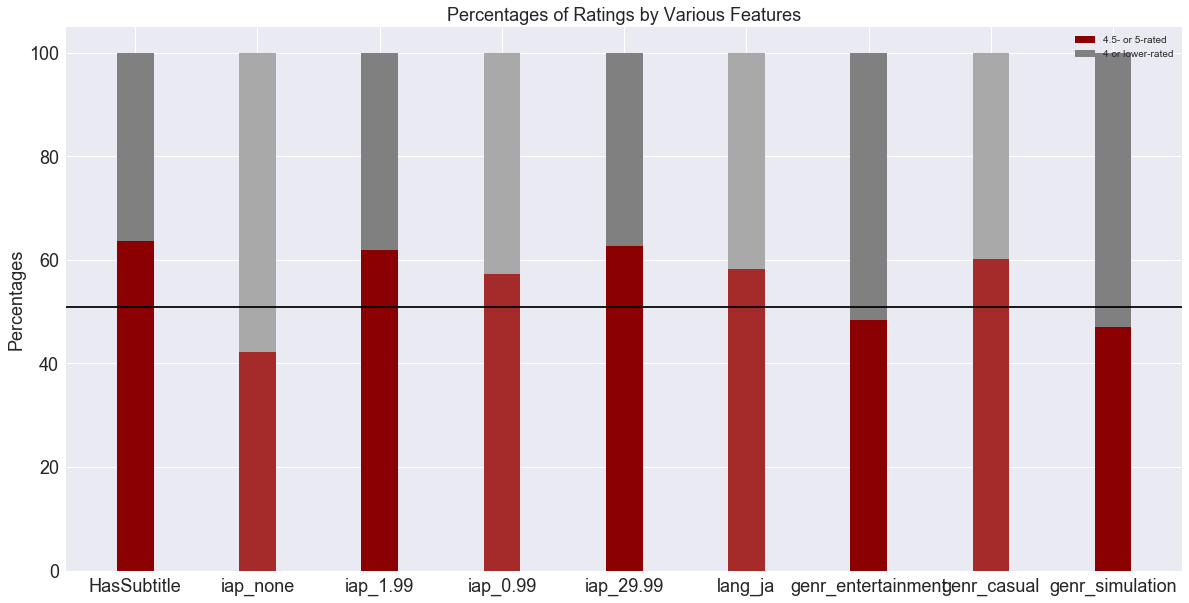

In [109]:
#looking at stacked bar charts of categorical features (that are 1's and 0's)
selectcols = ['HasSubtitle', 'iap_none', 'iap_1.99', 'iap_0.99', 'iap_29.99',
              'lang_ja', 'genr_entertainment', 'genr_casual', 'genr_simulation']
stackedbarchart(finaldf[selectcols],finaldf["Target"],"Various Features")

Based on this and the above appearance rates, I am concerned that a model may give more weight than necessary to those features where of the records that have it, over 60% of those have ratings of 4.5 or higher but the feature itself only appears in less than 10% of all records. In this case, those features are: `iap_29.99` and `genr_casual`.

In [110]:
finalbinsdf = getData("files/finalbins7464.csv")
finalbinsdf.describe()

,NameLength,HasSubtitle,DescripLength,iapb_none,iapb_1.99,iapb_0.99,iapb_19.49,lang_ja,lang_gu,genr_entertainment,genr_casual,genr_simulation,User Rating Count,Size,Target
count,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7.464000e+03,7.464000e+03,7464.000000
mean,23.552921,0.360263,1337.098875,0.387996,0.295954,0.383173,0.479502,0.181404,0.003617,0.492899,0.070070,0.164925,3.314929e+03,1.514538e+08,0.509512
std,14.942935,0.480109,967.395618,0.487326,0.456501,0.486192,0.499613,0.385378,0.060040,0.499983,0.255281,0.371138,4.258374e+04,2.560096e+08,0.499943
min,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,2.158400e+05,0.000000
25%,13.000000,0.000000,618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000e+01,3.053773e+07,0.000000
50%,20.000000,0.000000,1134.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000e+01,7.926989e+07,1.000000
75%,29.000000,1.000000,1812.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.080000e+02,1.772618e+08,1.000000
max,251.000000,1.000000,12494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.032734e+06,4.005591e+09,1.000000


The lowest appearance rate is 0.4% for `lang_gu`, followed by `genr_casual` at 7%.

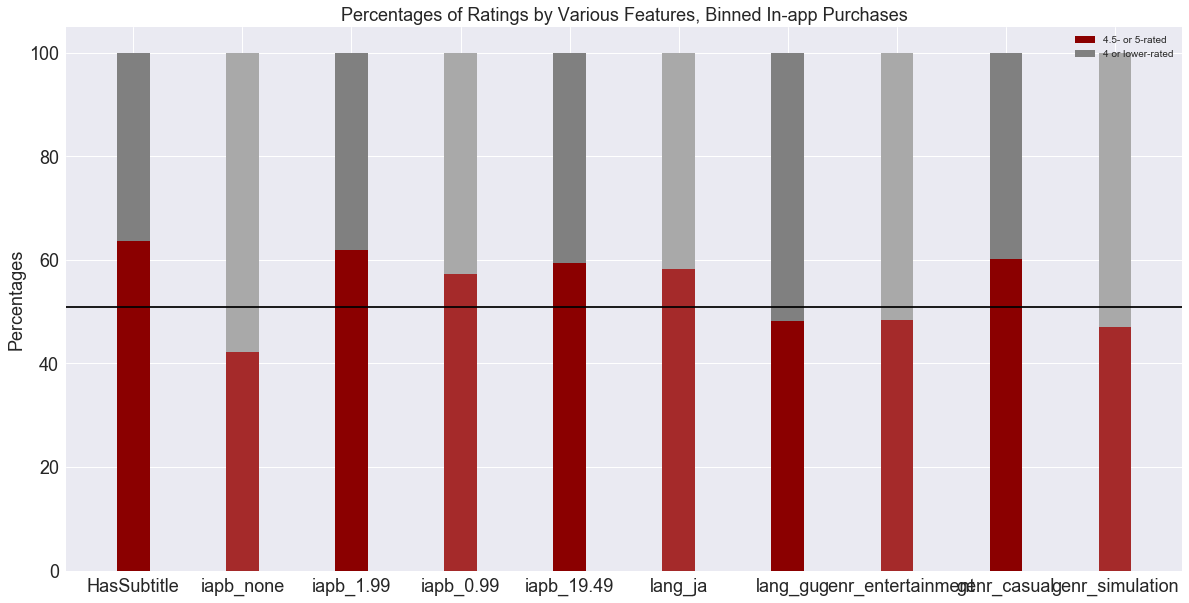

In [111]:
#graphing stacked bar charts for the binned dataframe:
selectcols = ['HasSubtitle', 'iapb_none', 'iapb_1.99', 'iapb_0.99', 'iapb_19.49', 'lang_ja',
              'lang_gu', 'genr_entertainment', 'genr_casual', 'genr_simulation']
stackedbarchart(finalbinsdf[selectcols],finalbinsdf["Target"],"Various Features, Binned In-app Purchases")

# Modeling
Trying different classifiers and comparing their accuracy metrics and then using grid search to tune hyperparameters.
## Establishing a baseline

In [112]:
#prints accuracy measures of model performance
def printacc(ytest,predictions):
    '''
    Runs various tests of accuracy from sklearn comparing y_test to predictions.  Specifically, confusion_matrix,
    f1_score and accuracy_score.
    
    Args
        ytest (arraylike) : target data the same shape as predictions, such as from train_test_split
        predictions (arraylike) : results from .predict method of the same shape as ytest, such as model.predict(X_test)
        
    Returns
        Prints the confusion_matrix, f1_score and accuracy_score if possible, otherwise prints "ran into an error".
        measures (list) : confusion_matrix, f1_score and accuracy_score if possible, otherwise np.nan
    '''
    measures=[]
    for each,name in zip([confusion_matrix,f1_score,accuracy_score],["confusion_matrix","f1_score","accuracy_score"]):
        try:
            measure = each(ytest,predictions)
            print(name,"\n",measure)
            measures.append(measure)
        except:
            measures.append(np.nan)
            print(f"The {name} ran into an error.")
    #end for loop
    return measures

In [113]:
def fitclassifier(dataframe,classifier,seed=56):
    '''
    Takes in dataframe, splits into train and test sets with test_size .25, fits classifier, checks performance against 
    test set.
    
    Args
        dataframe () : assumes target is stored in column labeled "Target"
        classifier () : an initialized classifer that needs only to be called with the .fit method and provides predictions
                        with .predict
        seed (int) : defaults to 56, for the random_state of dataframe's train_test_split
        
    Returns
        Prints sklearn.metrics confusion_matrix, f1_score, accuracy_score for dataframe's test set predicted by classifier
        scores (list) : the test set's accuracy measures in the order: confusion matrix, f1, accuracy score
    '''
    
    #separate dataframe into features and target
    X = dataframe.drop(columns=["Target"])
    y = dataframe.Target
    
    print("X and y are created.")#error-checking
    
    #split into training and test sets (75%-25%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=seed)
    print("Train-test split accomplished.")
    
    classifier.fit(X_train, y_train)#fit to training data
    print("The classifier has been fitted.")
    preds = classifier.predict(X_test)#make predictions with the test set
    print("Made predictions.")
    scores = printacc(y_test,preds)#prints accuracy measures, returns them in a list
    return scores #returns list of accuracy measurements

The features that have low feature importances will not be included in the models, contained in `dropfeats` and `dropbinsfeats`.

Running a "plain" gini `DecisionTreeClassifier` with the rest of the important features:

In [116]:
dropfeats = ['iap_0.99', 'iap_none']

In [117]:
clfdf = finaldf.drop(columns=dropfeats)
clfbinsdf =finalbinsdf.drop(columns=dropbinsfeats)

In [118]:
#seeing how well the gini model predicts
baseclf = DecisionTreeClassifier(criterion='gini') #initializing 'gini' DecisionTree
accuracylist = []
#using the clfdf which contains the features that had importances above 0.010
accuracylist.append(fitclassifier(clfdf,baseclf,5))

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[511 409]
 [400 546]]
f1_score 
 0.5744345081536033
accuracy_score 
 0.5664523043944266


In [119]:
#looking at accuracy measures for clfbinsdf
baseclf = DecisionTreeClassifier(criterion='gini')
accuracylist.append(fitclassifier(clfbinsdf,baseclf,5))

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[519 401]
 [391 555]]
f1_score 
 0.583596214511041
accuracy_score 
 0.5755627009646302


The binned version of the dataframe is slightly better for the f1 and accuracy scores.  The differences are small, but for simplicity, the binned `clfbinsdf` will be used for the rest of the notebook.

In [120]:
accuracylist

[[array([[511, 409],
         [400, 546]]), 0.5744345081536033, 0.5664523043944266],
 [array([[519, 401],
         [391, 555]]), 0.583596214511041, 0.5755627009646302]]

I can compare the models based on `clfbinsdf` in a dictionary to be easily viewed in a dataframe.

## Trying Various Models

In [121]:
#creating a dictionary to store the accuracy metrics from each model
accudict ={}

In [122]:
clf = DecisionTreeClassifier()
accudict["DecTree"]=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[518 402]
 [388 558]]
f1_score 
 0.5855194123819518
accuracy_score 
 0.5766345123258306


In [123]:
clf = DecisionTreeClassifier(criterion='entropy')
accudict["Entropy"]=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[530 390]
 [398 548]]
f1_score 
 0.5817409766454352
accuracy_score 
 0.5777063236870311


Typically you should scale data when fitting an SVM model. This is because if some variables have a larger scale than others, they will dominate variables that are on a smaller scale.

In [124]:
#scaling data before fitting SVM models
scaler = StandardScaler
scalecols = ["NameLength","DescripLength","User Rating Count","Size"]#only the non-categorical/binary columns need to be scaled down
scaledarr = scaler().fit_transform(clfbinsdf[scalecols].values)#fit the scaler

In [125]:
scaledcols = [col+"_scal" for col in scalecols]#rename scaled columns
scaledcols

['NameLength_scal',
 'DescripLength_scal',
 'User Rating Count_scal',
 'Size_scal']

In [126]:
scaledX = pd.DataFrame(scaledarr,index=clfbinsdf.index, columns=scaledcols)#convert numpy array of scaled data to dataframe
scaleddf = pd.concat([scaledX,clfbinsdf.drop(columns=scalecols)],axis="columns")#put with Target, other categorical columns

In [127]:
scaleddf.describe()

,NameLength_scal,DescripLength_scal,User Rating Count_scal,Size_scal,HasSubtitle,iapb_1.99,iapb_19.49,lang_ja,genr_entertainment,genr_casual,genr_simulation,Target
count,7.464000e+03,7.464000e+03,7.464000e+03,7.464000e+03,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000
mean,-5.330974e-17,-3.807839e-17,-3.807839e-18,4.569407e-17,0.360263,0.295954,0.479502,0.181404,0.492899,0.070070,0.164925,0.509512
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,0.480109,0.456501,0.499613,0.385378,0.499983,0.255281,0.371138,0.499943
min,-1.509371e+00,-1.376053e+00,-7.773273e-02,-5.907909e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.062620e-01,-7.433846e-01,-7.756834e-02,-4.723425e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.377818e-01,-2.094411e-01,-7.676986e-02,-2.819769e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.645498e-01,4.909397e-01,-7.061686e-02,1.008154e-01,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.522206e+01,1.153370e+01,7.114504e+01,1.505567e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The selected features were successfully scaled down.

In [128]:
#SVC linear (simple) - data would be very unlikely to fit well
clf = svm.SVC(kernel='linear')#max_iter defaults to -1 for no limit to number of iterations in solver
accudict["Linear SVC"] = fitclassifier(scaleddf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[678 242]
 [499 447]]
f1_score 
 0.5467889908256881
accuracy_score 
 0.6028938906752411


In [129]:
#SVC poly
clf = svm.SVC(kernel='poly',gamma='scale')
accudict["Poly SVC scale"]=fitclassifier(scaleddf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[649 271]
 [425 521]]
f1_score 
 0.5995397008055235
accuracy_score 
 0.6270096463022508


In [130]:
#SVC rbf
clf = svm.SVC(kernel='rbf',gamma='scale')
accudict["RBF SVC scale"]=fitclassifier(scaleddf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[583 337]
 [361 585]]
f1_score 
 0.6263383297644539
accuracy_score 
 0.6259378349410504


In [131]:
clf = RandomForestClassifier(criterion='entropy',n_estimators=10)#default n_estimators will be 100 in version .22
accudict["Entropy Forest"]=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[613 307]
 [434 512]]
f1_score 
 0.5801699716713882
accuracy_score 
 0.6028938906752411


In [132]:
clf = RandomForestClassifier(criterion='gini',n_estimators=10)#default n_estimators will be 100 in version .22
accudict["Gini Forest"]=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[629 291]
 [434 512]]
f1_score 
 0.585477415666095
accuracy_score 
 0.6114683815648446


In [133]:
clf = AdaBoostClassifier()
accudict["AdaBoost"]=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[578 342]
 [350 596]]
f1_score 
 0.6326963906581742
accuracy_score 
 0.6291532690246516


In [134]:
clf = XGBClassifier()
accudict["XGBoost"]=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[602 318]
 [370 576]]
f1_score 
 0.6260869565217391
accuracy_score 
 0.6312968917470525


In [135]:
#creating a dataframe to look at all the accuracy metrics' results
accuframe = pd.DataFrame(accudict,index=["confusion matrix","f1 score","accuracy score"])
accuframe

,DecTree,Entropy,Linear SVC,Poly SVC scale,RBF SVC scale,Entropy Forest,Gini Forest,AdaBoost,XGBoost
confusion matrix,"[[518, 402], [388, 558]]","[[530, 390], [398, 548]]","[[678, 242], [499, 447]]","[[649, 271], [425, 521]]","[[583, 337], [361, 585]]","[[613, 307], [434, 512]]","[[629, 291], [434, 512]]","[[578, 342], [350, 596]]","[[602, 318], [370, 576]]"
f1 score,0.585519,0.581741,0.546789,0.59954,0.626338,0.58017,0.585477,0.632696,0.626087
accuracy score,0.576635,0.577706,0.602894,0.62701,0.625938,0.602894,0.611468,0.629153,0.631297


The highest accuracy metrics are the f1 for AdaBoost, RBF (Radial Basis Function) and XGBoost; and the accuracy score for XGBoost, AdaBoost, RBF and Gini Forest.

## Tuning Hyperparameters with GridSearch
After determining the most accurate model, then the hyperparameters will be tuned.  It is more beneficial with regards to processing time relative to the improvement in accuracy to do it this way.  Tuning hyperparameters yields only a slight benefit for a large amount of work so it will be tuned after the model has been chosen.

In [136]:
#try with AdaBoost
#default base_estimator is DecisionTreeClassifier with max_depth=1
grid = [{'clf__n_estimators':[10,25,50,75,100,150],
         'clf__learning_rate':[.1,.25,.5,1,1.5,2],'clf__algorithm':['SAMME', 'SAMME.R']}]
#n_estimators and learning_rate have a trade-off

In [137]:
#create Pipeline
pipe = Pipeline([('clf',AdaBoostClassifier(random_state=5))])

In [138]:
#set up GridSearchCV
gs_ada = GridSearchCV(estimator=pipe,
            param_grid=grid, scoring='f1', #f1 scoring uses a binary target
            cv=3, verbose=2, return_train_score = True,n_jobs=-1)

In [139]:
#create training and test split for the AdaBoost GridSearch
X = clfbinsdf.drop(columns=["Target"])
y = clfbinsdf.Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [140]:
#for RBF
#get training and test sets using scaled version of data (scaleddf)
X = scaleddf.drop(columns=["Target"])
y = scaleddf.Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=5)

In [141]:
start = time.time()

gs_ada.fit(X_train, y_train)

end = time.time()
print("It took %.3f seconds long." % (end-start))

print('Best accuracy: %.3f' % gs_ada.best_score_)

bestparamdict = gs_ada.best_params_
print('The optimal parameters were:')
for param in sorted(bestparamdict.keys()):
    print('%s: %r' % (param, bestparamdict[param]))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   13.4s finished


It took 13.709 seconds long.
Best accuracy: 0.630
The optimal parameters were:
clf__algorithm: 'SAMME.R'
clf__learning_rate: 0.25
clf__n_estimators: 75


In [142]:
train_preds = gs_ada.predict(X_train)
preds = gs_ada.predict(X_test)

print("The accuracy metrics for the training set:")
trainmetrics = printacc(y_train, train_preds)

print("The accuracy metrics for the test set:")
testmetrics = printacc(y_test, preds)

The accuracy metrics for the training set:
confusion_matrix 
 [[1741 1000]
 [1060 1797]]
f1_score 
 0.6356561726211531
accuracy_score 
 0.6320114326545194
The accuracy metrics for the test set:
confusion_matrix 
 [[592 328]
 [346 600]]
f1_score 
 0.6403415154749199
accuracy_score 
 0.6387995712754555


Now fitting an AdaBoostClassifier model with the optimal parameters:

In [143]:
#optimal parameters: (algorithm = 'SAMME.R', learning_rate = .25, n_estimators=75)
clf = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = .25, n_estimators=75)
AdaBacc=fitclassifier(clfbinsdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[592 328]
 [346 600]]
f1_score 
 0.6403415154749199
accuracy_score 
 0.6387995712754555


The f1 score is 64%, which is only slightly improved from the AdaBoostClassifier without using optimal parameters: 63%.

It would be interesting to see how well the model performs with only the features that had `feature_importances_` above $0.05$: `User Rating Count`, `HasSubtitle`, `Size`, `DescripLength` and (rounding up from $0.048$) `genr_simulation`.

In [144]:
importantdf = clfbinsdf[["User Rating Count","HasSubtitle","Size","DescripLength","genr_simulation","Target"]]
importantdf.head(2)

,User Rating Count,HasSubtitle,Size,DescripLength,genr_simulation,Target
0,3553.0,0.0,15853568.0,1617.0,0.0,0.0
1,284.0,0.0,12328960.0,1222.0,0.0,0.0


In [145]:
#fitting classifier with optimal paramters to only the top five important features
clf = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = .25, n_estimators=75)
AdaBacc=fitclassifier(importantdf,clf,5)

X and y are created.
Train-test split accomplished.
The classifier has been fitted.
Made predictions.
confusion_matrix 
 [[603 317]
 [396 550]]
f1_score 
 0.6067291781577496
accuracy_score 
 0.6178992497320471


That appeared to lower the f1 score to about 60% so using this few features, even if they do have the five highest `feature_importances_`, does not provide an improved result.

### Plots for Presentation

In [146]:
sorted(finalbinsfeats.items(),key=lambda item: item[1],reverse=True)

[('User Rating Count', 0.3042687409219296),
 ('HasSubtitle', 0.2819052585256443),
 ('Size', 0.13044393462097273),
 ('DescripLength', 0.08349237098949114),
 ('genr_simulation', 0.04817308594114681),
 ('genr_casual', 0.03321259326943433),
 ('iapb_1.99', 0.028601838386621937),
 ('NameLength', 0.022537061991685977),
 ('genr_entertainment', 0.02110888023026936),
 ('lang_ja', 0.019160838775017366),
 ('iapb_19.49', 0.011953178569926271),
 ('iapb_0.99', 0.006258619798139817),
 ('lang_gu', 0.0060387707987479),
 ('iapb_none', 0.0028448271809726434)]

# Interpretation
## Plotting and doing t-tests for the top few features
Creating graphs to see the distributions of each of these features with respect to the target variable.
Followed by a t-test to check for significance.

In [147]:
#almost the dataframe used in the final model, except that one dropped the three lower-importance features
finalbinsdf = pd.read_csv("files/finalbins7464.csv",index_col=[0])
finalbinsdf.describe()

,NameLength,HasSubtitle,DescripLength,iapb_none,iapb_1.99,iapb_0.99,iapb_19.49,lang_ja,lang_gu,genr_entertainment,genr_casual,genr_simulation,User Rating Count,Size,Target
count,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7464.000000,7.464000e+03,7.464000e+03,7464.000000
mean,23.552921,0.360263,1337.098875,0.387996,0.295954,0.383173,0.479502,0.181404,0.003617,0.492899,0.070070,0.164925,3.314929e+03,1.514538e+08,0.509512
std,14.942935,0.480109,967.395618,0.487326,0.456501,0.486192,0.499613,0.385378,0.060040,0.499983,0.255281,0.371138,4.258374e+04,2.560096e+08,0.499943
min,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,2.158400e+05,0.000000
25%,13.000000,0.000000,618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000e+01,3.053773e+07,0.000000
50%,20.000000,0.000000,1134.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000e+01,7.926989e+07,1.000000
75%,29.000000,1.000000,1812.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.080000e+02,1.772618e+08,1.000000
max,251.000000,1.000000,12494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.032734e+06,4.005591e+09,1.000000


In [148]:
#the original dataframe, minus duplicates and most rows with null values
edadf = getData("files/data7464.csv")
edadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464 entries, 0 to 16993
Data columns (total 18 columns):
URL                             7464 non-null object
ID                              7464 non-null int64
Name                            7464 non-null object
Subtitle                        2689 non-null object
Icon URL                        7464 non-null object
Average User Rating             7464 non-null float64
User Rating Count               7464 non-null float64
Price                           7464 non-null float64
In-app Purchases                4573 non-null object
Description                     7464 non-null object
Developer                       7464 non-null object
Age Rating                      7464 non-null object
Languages                       7464 non-null object
Size                            7464 non-null float64
Primary Genre                   7464 non-null object
Genres                          7464 non-null object
Original Release Date           7464 non-

#### Considering User Rating Count

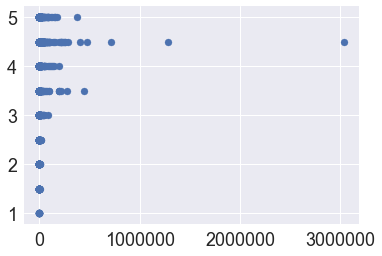

In [149]:
#plot of User Rating Count against the original target from edadf (Average User Rating)
plt.scatter(edadf["User Rating Count"],edadf["Average User Rating"])
plt.show()

It does look like higher-rated apps have a higher number of users that have rated them.

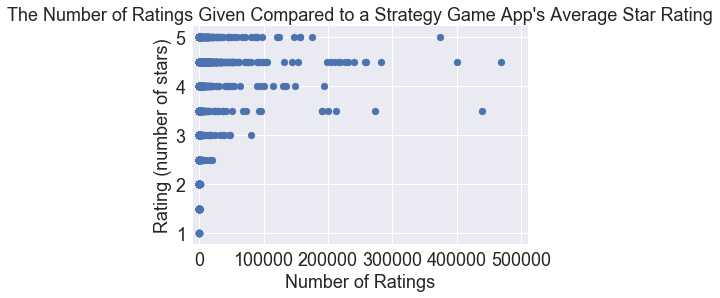

In [150]:
#cut off chart at 500000 on the x-axis
plt.scatter(edadf["User Rating Count"],edadf["Average User Rating"])
plt.xlim(-10000, 510000)
plt.ylabel("Rating (number of stars)")
plt.xlabel("Number of Ratings")
plt.title("The Number of Ratings Given Compared to a Strategy Game App's Average Star Rating")
plt.show()

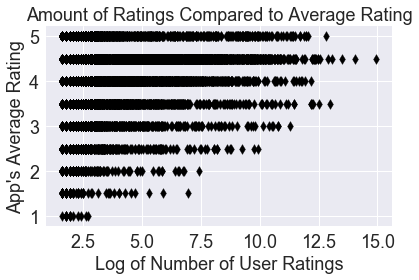

In [151]:
#a version with log-scaled User Rating Count
plt.scatter(np.log(edadf["User Rating Count"]),edadf["Average User Rating"],marker="d",c="black")
plt.ylabel("App's Average Rating")
plt.xlabel("Log of Number of User Ratings")
plt.title("Amount of Ratings Compared to Average Rating")
plt.tight_layout()
plt.savefig("images/Distribution of Rating Count.png")

There appears to be a trend that as the average rating increases, so does the number of ratings.  As a hypothesis test:

$H_0$ : The mean difference between the number of ratings for lower-rated apps and those of higher-rated apps is zero or greater than zero. Rephrased, $\mu_{lower} \ge \mu_{higher}$

$H_1$ : The mean difference between the number of ratings for lower-rated apps and those of higher-rated apps is less than zero. When $\mu_{lower} < \mu_{higher}$.

To prove the alternative hypothesis, I need a one-tailed less-than test.

With the $p$ and $t$ values from a two-tailed test (returned by `ttest_ind`), I can reject the null hypothesis of a less-than test when $p \div 2 < \alpha$ (where $p$ is significant for an $\alpha$ of 0.05) and $t < 0$ because those would indicate that $\mu_{lower}$ has to be less than $\mu_{higher}$.

In [152]:
def splitbyTarget(series, targetdf):
    '''
    Split series into two based on each item in series' corresponding value in targetdf for the same index.
    
    Args
        series (pandas Series) : a Series with the same index as targetdf
        targetdf (pandas Series) : a Series where a value of 1 means that the record at that index matches the target and
                                    0 means it does not
    
    Returns
        isTarget (pandas Series) : a Series of values from series that match the target (1 in targetdf)
        notTarget (pandas Series) : a Series of values from series that do not match the target (0 in targetdf)
    '''
    
    #filter to get the indices that have value of 1 in the target
    indices_1 = targetdf.loc[targetdf==1].index #the index from the target where the values are 1
    isTarget = series[indices_1] #filtering target by selected indices
    
    #filter to get indices that have value 0 in the target
    indices_0 = targetdf.loc[targetdf==0].index #the index from the target where the values are 0
    notTarget = series[indices_0] #using that index to get the corresponding values in series
        
    return isTarget, notTarget

In [154]:
#split User Rating Count into higher and lower ratings
higher_count,lower_count = splitbyTarget(finalbinsdf["User Rating Count"],finalbinsdf.Target)

In [155]:
#convert to lists for t-test
highclist = [high_rating for high_rating in higher_count]
lowclist =[low_rating for low_rating in lower_count]

In [156]:
# a t-test to compare Average User Ratings (with Target) and User Rating Count
# for alternative hypothesis mean(lower) < mean(higher),
#needs mean(higher)-mean(lower) which is (higher, lower):
countresults = stats.ttest_ind(highclist,lowclist)
countresults

Ttest_indResult(statistic=3.571877625404681, pvalue=0.0003566642909901036)

In [157]:
def onetailresult(results, alpha=0.05):
    '''
    Print a statement saying whether the test results from ttest_ind were significant or not,
    for a one-tailed test.  Since ttest_ind returns numbers for a two-tailed test, this divides
    the p-value by 2 before comparing it to the alpha.  If the t-statistic is negative, it 
    compares 1 - p/2 to alpha.
    
    Args:
        results (Ttest_indResult or 1-D arraylike) : where the t-statistic is the first entry 
                                                    and the p-value is the second.
        alpha (float) : defaults to 0.05, the threshold for below which the p-value is significant
    
    Returns:
        Prints sentence with the statistic, true p-value and whether it is significant.
    '''
    #divide p by 2, check if it's less than alpha
    alpha = 0.05
    zresult = results[0]>0#first result is the statistic and if positive, is the z score
    pvalue = results[1]/2
    if zresult: #if statistic is positive
        presult = pvalue<=alpha #check if p is smaller than alpha
    else: #if statistic is negative,
        presult = (1-pvalue)<=alpha #the real p-value is 1-p/2
        pvalue=1-pvalue
    
    if presult:
        print(f"With statistic {results[0]} and p-value {pvalue}, the result is significant.")
    else:#if the p-value is greater than the alpha
        print(f"With statistic {results[0]} and p-value {pvalue}, the result is not significant.")

In [158]:
onetailresult(countresults)

With statistic 3.571877625404681 and p-value 0.0001783321454950518, the result is significant.


This means the null hypothesis can be rejected and the alternative hypothesis is proven.  Lower-rated apps have significantly fewer user ratings (a smaller User Rating Count).

In [159]:
#function to graph stacked bar charts of one categorical feature and its inverse with an option to save
def barchart(seriesdata,binarytarget,titlename,toSave=False, barwidth=0.3):
    '''
    Plots a stacked bar chart created by comparing the column given by seriesdata and its inverse to the binarytarget.  All 
        records that possess the feature (represented by a 1 in seriesdata) have percentages taken of whether they match
        binarytarget or not (if the value at the same index is 1 or 0). The other bar in this stacked bar chart is made
        from the inverse of seriesdata, so it looks at those records without the feature and compares them to binarytarget.
        Each bar in the plot is split into the two percentages of whether they match binarytarget. The graph also has a 
        horizontal black line at 51, which is the binarytarget ratio across the entire dataset (51% are 1, 49% are 0). 
        The percentage of positive for the target on the bottom of the stacked chart and negative on the top.
    
    Args
        seriesdata (pandas Series) : a series made up of 1's and 0's only with the same indices as binarytarget, to be 
                                    plotted as a stacked bar chart and its inverse is if 1's were 0's and 0's were 1's.
        binarytarget (pandas Series) : the target with the same indices as seriesdata, in 1's and 0's only, against which 
                                    to compare the data in seriesdata, where 1's are higher ratings and 0's are lower
        titlename (str) : the desired title of the plot and if toSave is True, the plot image is titlename.png
        toSave (bool) : defaults to False, to display (False, using .show) or to save as .PNG (True, using .savefig)
        barwidth (float or int) : defaults to 0.3, determines how wide the bars are relative to the rest of the plot
    
    Returns
        displays a plot of the stacked bar graph
    '''
    #each of the two groups becomes an array-like of values
    ind = [1,3]#locations on the x-axis for each stacked bar
    
    #turn series into dataframe
    seriesdata = seriesdata.to_frame()
    
    #create inverse of seriesdata
    colname = seriesdata.columns[0]
    invcolname = colname+"_inv"
    seriesdata[invcolname] = [0 if i else 1 for i in seriesdata[colname]]
    
    #get percentages for both
    yesTarget, noTarget = barPercentages(seriesdata,binarytarget) #percentages without having the feature
    
    colors = [["darkred","brown"],["gray","darkgray"]]#alternating colors
    
    plt.figure(figsize=(6,10))
    bars1 = plt.bar(ind, yesTarget, barwidth, color=colors[0]) #the positives for the target
    bars2 = plt.bar(ind, noTarget, barwidth, bottom=yesTarget, color=colors[1]) #that do not have the target

    plt.axhline(51,color="k")#Target is 51%-49% distribution

    pts = 18 #font pt size

    plt.rc('axes', titlesize=pts, labelsize=pts)     # font size of the axes titles and labels
    plt.rc('xtick', labelsize=pts)    # font size of the tick labels
    plt.rc('ytick', labelsize=pts)    # font size of the tick labels
    plt.rc('figure', titlesize=pts+2) #title font size, slightly larger than the other text
    
    plt.ylabel('Percentages')
    plt.title(titlename)
    plt.xticks(ind, [colname,"Not "+colname])
    
    plt.legend((bars1[0], bars2[0]), ('4.5- or 5-rated', '4 or lower-rated'))#assuming binarytarget is from User Ratings
    if toSave==False:
        plt.show()
    else:
        plt.savefig("images/"+titlename+".png")

#### Considering HasSubtitle
The ratings of apps with subtitles compared to ratings of apps without.

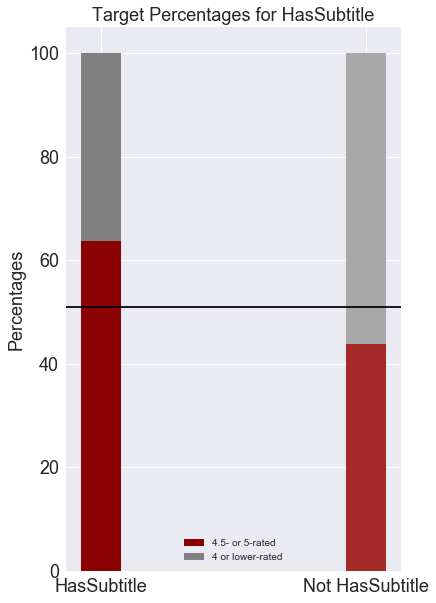

In [160]:
#looking at HasSubtitle
barchart(finalbinsdf["HasSubtitle"],finalbinsdf["Target"],"Target Percentages for HasSubtitle",True)

In [162]:
finalbinsdf.groupby('HasSubtitle')['Target'].mean()

HasSubtitle
0.0    0.438115
1.0    0.636296
Name: Target, dtype: float64

##### Hypothesis test for HasSubtitle

A hypothesis test to check whether significantly more apps with higher ratings have a subtitle compared to apps with lower ratings:

$H_0$ : The mean difference between the distributions, across `HasSubtitle`, of lower-rated apps and higher-rated apps is zero or greater than zero, or $\mu_{lower} \ge \mu_{higher}$

$H_1$ : The mean difference between the distributions across `HasSubtitle` for lower-rated apps and higher-rated apps is less than zero, or $\mu_{lower} < \mu_{higher}$.

To prove the alternative hypothesis by rejecting the null hypothesis, I use a one-tailed less-than test.

In [163]:
#from HasSubtitle by looking at Target
higher_sub, lower_sub = splitbyTarget(finalbinsdf.HasSubtitle,finalbinsdf.Target)

In [164]:
hsublist = [higher_rating for higher_rating in higher_sub]
lsublist = [lower_rating for lower_rating in lower_sub]

In [165]:
results_sub = stats.ttest_ind(hsublist, lsublist)

In [166]:
onetailresult(results_sub)

With statistic 16.746329541306363 and p-value 4.010618646239367e-62, the result is significant.


Thus, the null hypothesis $\mu_{lower} \ge \mu_{higher}$ is rejected and the alternative $\mu_{lower} < \mu_{higher}$ must be true.  So, apps with lower ratings have a subtitle less often on average than apps with higher ratings.

#### Comparing App Size

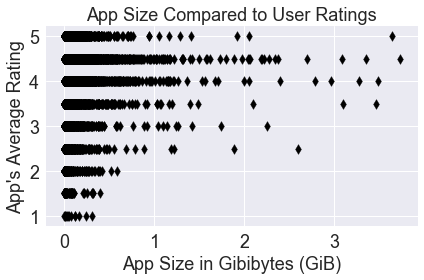

In [167]:
#looking at Size (in bytes), converted to Gibibytes
plt.scatter(edadf["Size"]/(1024**3),edadf["Average User Rating"],marker="d",c="black")
plt.ylabel("App's Average Rating")
plt.xlabel("App Size in Gibibytes (GiB)")
plt.title("App Size Compared to User Ratings")
plt.tight_layout()#so xlabel is not cut off when saving the figure
plt.savefig("images/Distribution of Size.png")

Apps with sizes larger than $1.07\times 10^9$ bytes (about 1 Gibibyte) appear to have higher ratings.  Similarly, few apps larger than 2 GiB have ratings below 4.  However, the apps with a rating of 5 (the highest possible) are mostly under 1.5 GiB while it's more common for those rated 4.5 to be as large as 2.5 GiB.

##### A note on converting bytes, with help from Wikipedia
https://en.wikipedia.org/wiki/Mebibyte

Since the computer architecture is built on the binary bit (1 or 0), amounts of bytes scale by powers or multiples of two.  International standards bodies created the term Mebibyte, and others, to refer to these larger amounts and to make this distinction because a prefix like "mega" has the specific meaning of 1 million, for instance. This is a fairly recent nomenclature decision in the history of computing, so many people (inside and outside the field) still consider a megabyte to be $1024^2$ bytes.

A megabyte is 1 million bytes:
1 Megabyte (MB) = $1000^2$ bytes = 1,000,000 bytes = $5^6\times2^{6}$ bytes

A mebibyte is $1024^2$ bytes:
1 Mebibyte (MiB) = $1024^2$ bytes = 1,048,576 bytes = $2^{20}$ bytes

1 Gibibyte (GiB) = 1024 MiB = $1024^3$ bytes = 1,073,741,824 bytes = $2^{30}$ bytes

##### Hypothesis Test

A hypothesis test to check for significance of whether apps with higher ratings have more bytes compared to apps with lower ratings:

$H_0$ : The mean difference between the sizes of lower-rated apps and those of higher-rated apps is zero or greater than zero, or $\mu_{lower} \ge \mu_{higher}$

$H_1$ : The mean difference between the sizes of lower-rated apps and those of higher-rated apps is less than zero, or $\mu_{lower} < \mu_{higher}$.

To prove the alternative hypothesis by rejecting the null hypothesis, I use a one-tailed less-than test.

In [175]:
finalbinsdf.groupby('Target')['Size'].mean().round()

Target
0.0    139023396.0
1.0    163420158.0
Name: Size, dtype: float64

In [171]:
finalbinsdf.Size.nunique()

7305

In [172]:
#compare average sizes from Size by looking at Target
higher_size, lower_size = splitbyTarget(finalbinsdf.Size,finalbinsdf.Target)

In [173]:
higher_size

59        55803904.0
78       500501504.0
82        33033216.0
91        39997440.0
118       47129600.0
            ...     
16932     44067840.0
16956     79646720.0
16962    125348864.0
16967    128687104.0
16993      8845312.0
Name: Size, Length: 3803, dtype: float64

In [ ]:
hslist = [higher_rating for higher_rating in higher_size]
lslist = [lower_rating for lower_rating in lower_size]

In [ ]:
results_sz = stats.ttest_ind(hslist, lslist)

In [ ]:
onetailresult(results_sz)

Thus, the null hypothesis $\mu_{lower} \ge \mu_{higher}$ is rejected and the alternative $\mu_{lower} < \mu_{higher}$ must be true.  So, apps with lower ratings have smaller sizes on average than apps with higher ratings.

#### Description Length (in Characters)

In [178]:
#filtering the DescripLength data using .loc
descripdict = {}
descripdict["Higher Ratings"] = finalbinsdf.loc[finalbinsdf["Target"]==1].DescripLength
descripdict["Lower Ratings"] = finalbinsdf.loc[finalbinsdf["Target"]==0].DescripLength

In [179]:
for key, values in descripdict.items():
    print(key) #printing the averages and standard deviations for each
    print(str(round(np.average(values),3))+" +/- "+str(round(np.std(values),3)))

Higher Ratings
1394.22 +/- 974.949
Lower Ratings
1277.762 +/- 955.745


There is a difference between the higher- and the lower-rated apps. Although the bulk of them overlap, the group of those with higher ratings have a higher average by about 100 characters.

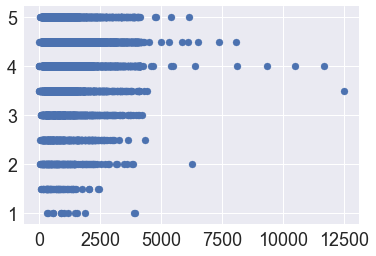

In [180]:
plt.scatter(finalbinsdf["DescripLength"],edadf["Average User Rating"])
plt.show()

In [181]:
hilodf = pd.DataFrame(descripdict)
hilodf.describe()

,Higher Ratings,Lower Ratings
count,3803.000000,3661.000000
mean,1394.219826,1277.762360
std,975.077489,955.875071
min,6.000000,6.000000
25%,640.000000,598.000000
50%,1198.000000,1066.000000
75%,1903.000000,1700.000000
max,8084.000000,12494.000000


NameError: name 'descripdict' is not defined

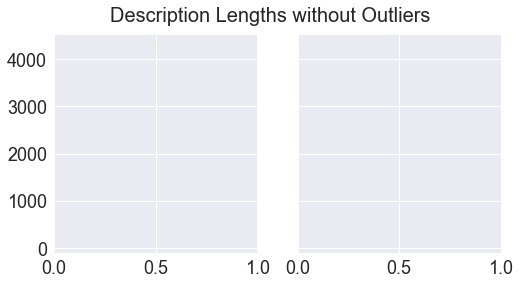

In [177]:
#boxplots of description length, separated into higher and lower
fig, (box1, box2) = plt.subplots(1, 2,sharex=True,sharey=True,figsize=(8,4))
plt.ylim(-100,4500)
fig.suptitle("Description Lengths without Outliers")
box1.boxplot(descripdict["Higher Ratings"])
box1.set_title("Higher-Rated")
box2.boxplot(descripdict["Lower Ratings"])
box2.set_title("Lower-Rated")
plt.xticks([],"box-plot")
plt.savefig("images/Description Box-Plots.png")
#plt.show()

The lower ratings are more clustered around a lower number just above 1000 characters, and the higher-rated Description lengths are longer, with the third quartile close to 2000. Below is a box plot for the combined data; all of the DescripLength column.

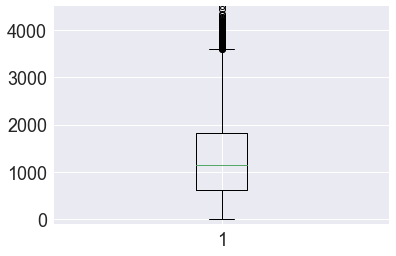

In [176]:
#plot of DescripLength to compare overall distribution
plt.boxplot(finalbinsdf["DescripLength"])
plt.ylim(-100,4500)
plt.show()

##### Hypothesis Test

A hypothesis test to check for significance of whether apps with higher ratings have longer descriptions compared to apps with lower ratings:

$H_0$ : The mean difference between the lower-rated apps' description lengths and those of higher-rated apps is zero or greater than zero, or $\mu_{lower} \ge \mu_{higher}$

$H_1$ : The mean difference between the description lengths (in characters) for lower-rated apps and those of higher-rated apps is less than zero, or $\mu_{lower} < \mu_{higher}$.

To prove the alternative hypothesis by rejecting the null hypothesis, I use a one-tailed less-than test.

In [182]:
#using descripdict["Higher Ratings"] and ["Lower Ratings"]
results_ds = stats.ttest_ind(descripdict["Higher Ratings"], descripdict["Lower Ratings"])

In [183]:
onetailresult(results_ds)

With statistic 5.208339729767996 and p-value 9.781581252580088e-08, the result is significant.


Thus, the null hypothesis $\mu_{lower} \ge \mu_{higher}$ is rejected and the alternative $\mu_{lower} < \mu_{higher}$ must be true.  So, apps with lower ratings have fewer characters in their descriptions on average than apps with higher ratings.

#### Considering the Simulation and Casual genres

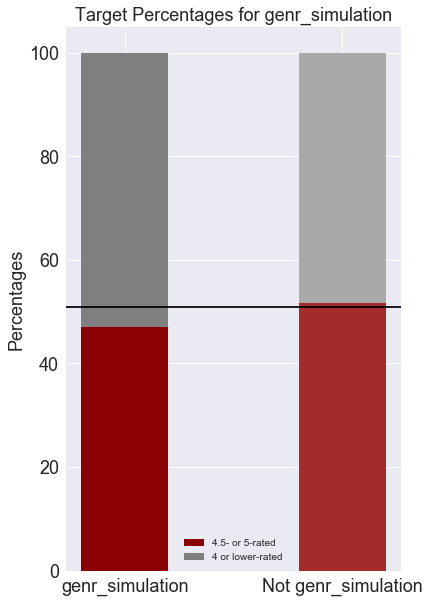

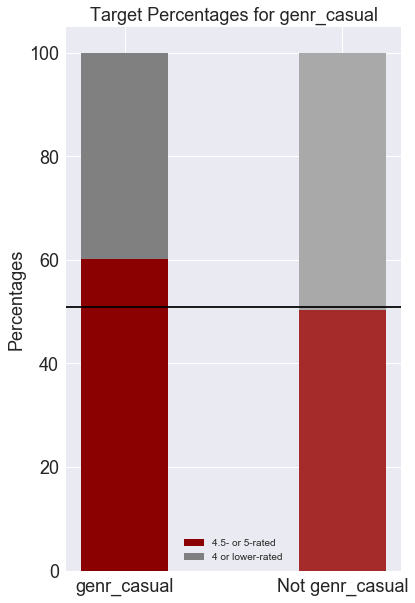

In [190]:
#looking at genr_simulation and genr_casual and those records without
for genrename in ["genr_simulation","genr_casual"]:
    barchart(finalbinsdf[genrename],finalbinsdf["Target"],"Target Percentages for "+genrename,barwidth=.8,toSave=True)

If an app is in the Simulation genre, it is likely to have a lower rating and if it is in the Casual genre, it is more likely to have a higher rating.  If it is not Casual, then it is closer to the average probability of a higher rating (51%). In this case, it appears that having the feature `genr_simulation` is a predictor of not having a higher rating.

##### Hypothesis test for Simulation genre

A hypothesis test to check whether significantly more apps with lower ratings fall into the simulation genre compared to apps with higher ratings:

$H_0$ : The mean difference between the distribution, across the simulation genre, of lower-rated apps and that of higher-rated apps is zero or less than zero, or $\mu_{lower} \le \mu_{higher}$

$H_1$ : The mean difference between the distributions across the simulation genre for lower-rated apps and higher-rated apps is greater than zero, or $\mu_{lower} > \mu_{higher}$.

To prove the alternative hypothesis by rejecting the null hypothesis, I use a one-tailed greater-than test.

In [189]:
finalbinsdf['genr_simulation'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: genr_simulation, dtype: float64

In [184]:
#from genr_simulation by looking at Target
higher_gsim, lower_gsim = splitbyTarget(finalbinsdf.genr_simulation,finalbinsdf.Target)

In [185]:
hsimlist = [higher_rating for higher_rating in higher_gsim]
lsimlist = [lower_rating for lower_rating in lower_gsim]

In [186]:
#for greater-than, the lower ratings go first to get a positive t-statistic
results_sim = stats.ttest_ind(lsimlist, hsimlist)

In [187]:
onetailresult(results_sim)

With statistic 2.946742382982834 and p-value 0.0016106708263357978, the result is significant.


Thus, the null hypothesis $\mu_{lower} \le \mu_{higher}$ is rejected and the alternative $\mu_{lower} > \mu_{higher}$ must be true.  So, apps with lower ratings on average fall into the Simulation genre than apps with higher ratings.

##### Hypothesis test for Casual genre

A hypothesis test to check whether significantly more apps with higher ratings fall into the casual genre compared to apps with lower ratings:

$H_0$ : The mean difference between the distributions, across the casual genre, of lower-rated apps and higher-rated apps is zero or greater than zero, or $\mu_{lower} \ge \mu_{higher}$

$H_1$ : The mean difference between the distributions across the casual genre for lower-rated apps and higher-rated apps is less than zero, or $\mu_{lower} < \mu_{higher}$.

To prove the alternative hypothesis by rejecting the null hypothesis, I use a one-tailed less-than test.

In [ ]:
#from the Casual genre by looking at Target
higher_gcas, lower_gcas = splitbyTarget(finalbinsdf.genr_casual,finalbinsdf.Target)

In [ ]:
hcaslist = [higher_rating for higher_rating in higher_gcas]
lcaslist = [lower_rating for lower_rating in lower_gcas]

In [ ]:
results_cas = stats.ttest_ind(hcaslist, lcaslist)

In [ ]:
onetailresult(results_cas)

Thus, the null hypothesis $\mu_{lower} \ge \mu_{higher}$ is rejected and the alternative $\mu_{lower} < \mu_{higher}$ must be true.  So, apps with lower ratings fall into the casual genre less often on average than apps with higher ratings.

### Comparing the rest of the top 11 important features
Using plots, checking to see whether possessing the feature or not is what correlates to a higher rating.

In [ ]:
#iapb_1.99
barchart(finalbinsdf["iapb_1.99"],finalbinsdf["Target"],"Target Percentages for In-app Purchases 1.99 or 1.49",
            barwidth=.8,toSave=True)

In [ ]:
#NameLength scatter plot with up to 120 chars
plt.scatter(finalbinsdf["NameLength"],edadf["Average User Rating"])
plt.xlim(-10,120)
plt.show()

In [ ]:
plt.scatter(finalbinsdf["NameLength"],finalbinsdf["Target"],marker="d",alpha=0.3)
#plt.xlim(-10,120)
plt.show()

In [ ]:
#picking out the NameLength data using .loc
namedict = {}
namedict["Higher Ratings"] = finalbinsdf.loc[finalbinsdf["Target"]==1].NameLength
namedict["Lower Ratings"] = finalbinsdf.loc[finalbinsdf["Target"]==0].NameLength

In [ ]:
for key, values in namedict.items():
    print(key) #printing the averages and standard deviations for each
    print(str(round(np.average(values),3))+" +/- "+str(round(np.std(values),3)))

The higher-rated apps' names range from roughly 9 to 37 characters in length and the lower-rated, from 8 to 40.  The lower-rated appear to have a very slightly flatter bell curve.  Although the differences are slight, the higher-rated apps' average length of a name is about 1 character shorter than the lower-rated apps'. Further research with t-tests or similar measures would determine the significance of this difference more precisely.

In [ ]:
#genr_entertainment, lang_ja, iapb_19.49
for eachname in ["genr_entertainment", "lang_ja", "iapb_19.49"]:
    barchart(finalbinsdf[eachname],finalbinsdf["Target"],"Target Percentages for "+eachname,barwidth=.8,toSave=True)

##### One-tailed t-test results for all except NameLength
Three of these have the same hypotheses and alternative hypotheses, namely:

$H_0$ : The mean difference between the distributions, across the Japanese language/ 1.99 bin/ 19.49 bin, of lower-rated apps and higher-rated apps is zero or greater than zero, or $\mu_{lower} \ge \mu_{higher}$

$H_1$ : The mean difference between the distributions across the Japanese language/ 1.99 bin/ 19.49 bin for lower-rated apps and higher-rated apps is less than zero, or $\mu_{lower} < \mu_{higher}$.

The entertainment genre is different:

$H_0$ : The mean difference between the distributions, across the entertainment genre, of lower-rated apps and higher-rated apps is zero or less than zero, or $\mu_{lower} \le \mu_{higher}$

$H_1$ : The mean difference between the distributions across the entertainment genre for lower-rated apps and higher-rated apps is greater than zero, or $\mu_{lower} > \mu_{higher}$.

In [ ]:
for colname in ["iapb_1.99","genr_entertainment", "lang_ja", "iapb_19.49"]:
    higher_r, lower_r = splitbyTarget(finalbinsdf[colname],finalbinsdf.Target)
    hlist = [higher_rating for higher_rating in higher_r]
    llist = [lower_rating for lower_rating in lower_r]
    if colname=="genr_entertainment":
        print("\n",colname,"greater-than test")
        results_ent = stats.ttest_ind(llist, hlist)
        onetailresult(results_ent)
    else:
        results = stats.ttest_ind(hlist, llist)
        print("\n",colname,"less-than test")
        onetailresult(results)

Thus, the null hypothesis $\mu_{lower} \ge \mu_{higher}$ is rejected and the alternative $\mu_{lower} < \mu_{higher}$ must be true for whether a game has a Japanese language option, or has in-app purchases in the 1.99 range or the 19.49 range (both are detailed in **Conclusion**, below).

##### Hypothesis test for NameLength
The remaining feature is the length of the app's name in characters.  This will check for significance of whether apps with higher ratings have fewer characters in their names than apps with lower ratings.

$H_0$ : The mean difference between the lengths of the names of lower-rated apps and higher-rated apps is zero or less than zero, or $\mu_{lower} \le \mu_{higher}$

$H_1$ : The mean difference between the lengths of names of lower-rated apps and higher-rated apps is greater than zero, or $\mu_{lower} > \mu_{higher}$.

In [ ]:
#using namedict
results_nl = stats.ttest_ind(namedict["Lower Ratings"], namedict["Higher Ratings"])

In [ ]:
onetailresult(results_nl)

Thus, the null hypothesis $\mu_{lower} \le \mu_{higher}$ is rejected and the alternative $\mu_{lower} > \mu_{higher}$ must be true.  So, apps with lower ratings have more characters in their names on average than apps with higher ratings.

# Conclusion
The best model for predicting whether an app rating would be more than 4.5 stars or not was the `AdaBoostClassifier` with the parameters(`algorithm` = '`SAMME.R`', `learning_rate` = 0.25 and `n_estimators` = 75).  The features that were included in this model were: 
1. User Rating Count : the number of ratings the app had
2. HasSubtitle : whether the app had a one-line summary
3. Size : the size of the app in bytes
4. DescripLength : how long the description text of the app was, in total characters (including newlines and punctuation)
5. genr_simulation : whether the app fell into the Simulation genre
6. genr_casual : whether the app fell into the Casual genre
7. iapb_1.99 : whether among the app's in-app purchases, at least one cost 1.99 or 1.49
8. NameLength : how many characters long the title of the game was (including punctuation and spaces)
9. genr_entertainment : whether the app fell into the Entertainment genre
10. lang_ja : whether one of its supported languages was Japanese
11. iapb_19.49 : whether among the app's in-app purchases, at least one cost more than 1.99 but less than 19.49 (Specifically, for this dataset: 2.49, 2.99, 3.49, 3.99, 4.49, 4.99, 5.49, 5.99, 6.99, 7.49, 7.99, 8.49, 8.99, 9.49, 9.99, 10.99, 11.99, 12.99, 13.99, 14.99, 15.99, 16.99, 17.99, 18.99 or 19.49.)

Each had a score greater than 0.010 as `feature_importances_` in the base classifier model (a "gini" type `DecisionTreeClassifier` with `max_depth` of 5).

With this model, a Strategy Game developer selling on the Apple App Store looking for a high rating (4.5 or 5) may want to consider shortening the advertised name of the app and check whether it's in the Simulation and/or Casual genre and adjust accordingly.  It's also not much of a concern what languages other than English the app is available in, except making a Japanese language option available might help. Frequent updates did not have much of an effect.

To increase the average user rating, this developer might add more content to the game, thereby necessitating an addition to the description text and increasing the size of the app.

Also, it might improve a Stratey Game app's rating to have the Name be more succinct and this could be done by moving some of the trimmed words to the Subtitle or Description.

## Future Opportunities, Further Research Questions
Bots or fake users can be bought to give a positive review, which is one way to increase the rating of an app.  However, legitimate reviewers may simply choose a number of stars to rate and leave no explanation for what it is they like or dislike about the app.  Often users are asked to rate an app from within the app itself.  There may be an incentive for doing so, like more in-game currency or something similarly valuable.  Many users are not aware that leaving a negative review has no negative effect on receiving the in-app reward.  Even though paying for *specifically* positive reviews (whether with in-app items of value or real-world money) is likely against the Terms and Policies of the app store, there is an implied quid pro quo that users may feel obligated to uphold (or they may be concerned about in-game repercussions if they give anything less than a 5).

On one occasion, I read about an app that had a pop-up asking the user whether they liked the app or not.  If they chose the affirmative, the link sent the user to the review page but if not, it linked to the Contact Us or provided a complaints form.  So an app with a high rating may well be deserved and could be due to addressing user complaints through the app itself, privately, and encouraging those without complaints to write a review.  Often, app developers reply to negative user reviews on the Google Play Store with an email address or link, asking for more details and in a way that's easier for them to address the issues raised in the review, but the negative review and low rating will still bring down the app's average rating until the user updates their rating.

Separating out true reviews from bots and identifying those five-star reviews that were incentivized would take more Natural Language Processing work, especially deciding on which criteria indicates a review is sincere.

Also, using NLP would be a more accurate way to determine exactly what users prefer or dislike about certain apps by analyzing the sincere reviews.